In [0]:
# !rm da*
# !rm mem*
# !rm sim*

from __future__ import absolute_import
from __future__ import print_function

from sklearn import metrics
# from memn2n import MemN2N
from itertools import chain
from six.moves import range, reduce
import re

import tensorflow as tf
from tensorflow import keras

import numpy as np

from google.colab import files

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

# uploaded = files.upload()
# uploaded = None

In [0]:
# ############################ data utils

def load_task(train_file, only_supporting=False, test_count = 11):
	train_data = parse_stories(train_file[:-1*test_count], only_supporting)
	test_data = parse_stories(train_file[-1*test_count:], only_supporting)
	return train_data, test_data

def load_task2(train_file, only_supporting=False, test_count = 10):
#   filter for binary rules
  train2_data = list()
  for line in train_file:
    line = line.replace('\n','')
#     line = str.lower(line)
  # 		line = str.lower(line)
#     print line
    _, qna = line.split('##') 
    if(len(qna.split(' '))==2):
      train2_data.append(line)
    
  train_data = parse_stories2(train2_data[:-1*test_count], only_supporting)
  test_data = parse_stories2(train2_data[-1*test_count:], only_supporting)
  print('lens',len(train2_data),'#',len(train_data),'#',len(test_data))
  return train_data, test_data

def load_task3(train_file, only_supporting=False, test_count = 10):
#   filter for binary rules
  train2_data = list()
  for line in train_file:
    line = line.replace('\n','')
#     line = str.lower(line)
  # 		line = str.lower(line)
#     print line
    _, qna = line.split('##') 
    if(len(qna.split(' '))==2):
      train2_data.append(line)
    
  train_data = parse_stories3(train2_data[:-1*test_count], only_supporting)
  test_data = parse_stories3(train2_data[-1*test_count:], only_supporting)
  print('lens',len(train2_data),'#',len(train_data),'#',len(test_data))
  return train_data, test_data

# len(parse_stories(train_data[:-11], False)),len(parse_stories(train_data[-11:], False))

def tokenize(sent):
	'''Return the tokens of a sentence including punctuation.
	>>> tokenize('Bob dropped the apple. Where is the apple?')
	['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
	'''
	return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
  '''Parse stories provided in the bAbI tasks format
  If only_supporting is true, only the sentences that support the answer are kept.
  '''
  # In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD

  data = []
  story = []
  for line in lines:
    story = []
    line = line.replace('\n','')
#     line = str.lower(line)
  # 		line = str.lower(line)
#     print line
    fact1, qna = line.split('##') 
    # q, a, supporting = line.split('\t')

#     a = tokenize(a)

    fact1 = tokenize(fact1)
    if fact1[-1] == "?" or fact1[-1] == ".":
      fact1 = fact1[:-1]

    story.append(fact1)
    #a = tokenize(a)
    # answer is one vocab word even if it's actually multiple words
#     a = [a]
 
    qna = qna.split(' ')
    if(len(qna)==2):
      q1, a1 = qna[:-1], qna[-1:]
      q1 = ' '.join(q1)
      q1 = tokenize(q1)  
      data.append((story, q1, a1))
               
  return data

def parse_stories2(lines, only_supporting=False):
  '''Parse stories provided in the bAbI tasks format
  If only_supporting is true, only the sentences that support the answer are kept.
  '''
  # In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD

  data = []
  story = []
  for line in lines:
    story = []
    line = line.replace('\n','')
#     line = str.lower(line)
  # 		line = str.lower(line)
#     print line
    fact1, qna = line.split('##') 
    # q, a, supporting = line.split('\t')

#     a = tokenize(a)

    fact1 = tokenize(fact1)
    if fact1[-1] == "?" or fact1[-1] == ".":
      fact1 = fact1[:-1]

    story.append(fact1)
    #a = tokenize(a)
    # answer is one vocab word even if it's actually multiple words
#     a = [a]
#     print('qna',qna) 
    qna = qna.split(' ')
    if(len(qna)==3):
      q1, a1 = qna[:-1], qna[-1:]
      q2, a2 = qna[:1],qna[1:2]
      q1 = ' '.join(q1)
      q1 = tokenize(q1)  
      data.append((story, q1, a1))   
      data.append((story, q2, a2))         
  return data


def parse_stories3(lines, q_position=-1, only_supporting=False):
    '''Parse stories provided in the bAbI tasks format
    If only_supporting is true, only the sentences that support the answer are kept.
    '''
    # In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD

    data = []
    story = []
    for line in lines:
        #     print('parseLine', line)
        story = []
        line = line.replace('\n', '')
        #     line = str.lower(line)
        # 		line = str.lower(line)
        #         print line
        fact1, qna = line.split('##')
        # q, a, supporting = line.split('\t')

        #     a = tokenize(a)

        fact1 = tokenize(fact1)
        if fact1[-1] == "?" or fact1[-1] == ".":
            fact1 = fact1[:-1]

        for word in fact1:
            story.append(word)
        # story.append(fact1)
        # a = tokenize(a)
        # answer is one vocab word even if it's actually multiple words
        #     a = [a]
        #     print('qna',qna)
        qna = qna.split(' ')
        if (len(qna) == 2):
            q1, a1 = qna[:-1], qna[-1:]
            q1 = ' '.join(q1)
            q1 = tokenize(q1)
#             print('fact1, q1, a1', fact1, q1, a1)
            if(q_position == -1):
                q_position, a_index, min_dis = get_q_index(fact1, q1, a1)
#             print(q_position, a_index, min_dis)
                if (min_dis == 0):
                    continue
            # print(q_index, a_index, min_dis)
            data.append((story, q1, a1, q_position))
    return data
  
  
def vectorize_datas(data, word_idx, sentence_size, memory_size, q_position = -1):
    """
    Vectorize stories and queries.

    If a sentence length < sentence_size, the sentence will be padded with 0's.

    If a story length < memory_size, the story will be padded with empty memories.
    Empty memories are 1-D arrays of length sentence_size filled with 0's.

    The answer array is returned as a one-hot encoding.
    """
    S = []
    Q = []
    A = []
    print('data', data)
    for story, query, answer, q_position in data:
        # 		print('story', story)
        # story ['In', 'the', 'accompanying', 'diagram', 'of', 'circle', 'O', ',', 'the', 'measure', 'of', 'angle', 'ABC', 'is', '@', 'v_0', 'and', 'the', 'measure', 'of', 'arc', 'AC', 'is', '@', 'v_1']

        if (q_position == -1):
            q_position = story.index(query[0])
        
#         wo pos
        q_position = story.index(query[0])
        
        if (answer[0] not in story):
            continue
        ss = []
        for i, sentence in enumerate(story, 1):
            ls = 1
            # 			print('ls, sentence_size, sentence', ls, sentence, sentence_size, query)
            #       ls, sentence_size, sentence 1 accompanying 2 ['is']
            ss.append([word_idx[sentence]] + [0] * ls)
        # print('[word_idx[sentence]] + [0] * ls', [word_idx[sentence]] + [0] * ls)
        # 			print('ss', ss)

        # take only the most recent sentences that fit in memory
        ss = ss[::-1][:memory_size][::-1]

        # Make the last word of each sentence the time 'word' which
        # corresponds to vector of lookup table
        ss[q_position][-1] = len(word_idx) - memory_size
        # 		print('ss[q_position][-1] ', ss[q_position][-1], q_position )
        count = 0
        for i in range(q_position - 1, -1, -1):
            count += 1
            # 			print('i', i, ss[q_position][-1] - count)

            ss[i][-1] = ss[q_position][-1] - count

        count = 0
        for j in range(q_position + 1, len(ss)):
            count += 1
            # 			print('j', j, ss[q_position][-1] + count)

            ss[j][-1] = ss[q_position][-1] + count

        # print()

        # 		for i in range(len(ss)):
        # 			ss[i][-1] = len(word_idx) - memory_size - i + len(ss)
        #       i - q_position
        # 		print('ss1', ss)
        # pad to memory_size
        lm = max(0, memory_size - len(ss))
        for _ in range(lm):
            ss.append([0, 0])
        # print('ss2', ss)
        lq = max(0, sentence_size - len(query))
        q = [word_idx[w] for w in query] + [len(word_idx) - memory_size] * lq

        y = np.zeros(memory_size)  # 0 is reserved for nil word
        for a in answer:
            y = np.zeros(memory_size)
            y[story.index(answer[0])] = 1

        S.append(ss)
        # 		print(q_position, 'ss23', ss)
        Q.append(q)
        A.append(y)
    return S, np.array(Q), np.array(A)


def vectorize_data(story, query, answer, word_idx, 
                   sentence_size, memory_size, q_position = -1, S=[],Q=[],A=[] ):
		S = []
		Q = []
		A = []
		ss = []
		if(q_position == -1):
			q_position = story.index(query[0])
      
# wo pos
		q_position = story.index(query[0])
		for i, sentence in enumerate(story, 1):
			ls = 1
# 			print('ls, sentence_size, sentence', ls, sentence_size, sentence)
			ss.append([word_idx[sentence]] + [0] * ls)
#
		# take only the most recent sentences that fit in memory
		ss = ss[::-1][:memory_size][::-1]
# 		print('len11',len(ss))  
		# Make the last word of each sentence the time 'word' which 
		# corresponds to vector of lookup table
		ss[q_position][-1] = len(word_idx) - memory_size
# 		print('ss[q_position][-1] ', ss[q_position][-1], q_position )
		count = 0
		for i in range(q_position-1,-1, -1):
			count +=1
# 			print('i', i, ss[q_position][-1] - count)
      
			ss[i][-1] = ss[q_position][-1] -count
      
		count = 0      
		for j in range(q_position+1, len(ss) ):
			count +=1
# 			print('j', j, ss[q_position][-1] + count)
      
			ss[j][-1] = ss[q_position][-1] +count
		lm = max(0, memory_size - len(ss))
		for _ in range(lm):
			ss.append([0,0])
# 		print('len13',len(ss)) 
		lq = max(0, sentence_size - len(query))
		q = [word_idx[w] for w in query] + [len(word_idx) - memory_size] * lq

		y = np.zeros(len(word_idx) + 1) # 0 is reserved for nil word
		for a in answer:
			y = np.zeros(memory_size)      
			y[0] = 1
    
# 		print('len1S',len(S))     
		S.append(ss)
		Q.append(q)
		A.append(y)
# 		print('len12S',len(S))    
		return S,Q,A      

def vectorize_question(story, query, answer, word_idx, sentence_size, memory_size,S=[],Q=[],A=[] ):
		Q = []
		lq = max(0, sentence_size - len(query))
		q = [word_idx[w] for w in query] + [0] * lq
		Q.append(q)
		return Q      


def vectorize_datas_for_multiple(data, word_idx, sentence_size, memory_size):
	"""
	Vectorize stories and queries.

	If a sentence length < sentence_size, the sentence will be padded with 0's.

	If a story length < memory_size, the story will be padded with empty memories.
	Empty memories are 1-D arrays of length sentence_size filled with 0's.

	The answer array is returned as a one-hot encoding.
	"""
	S = []
	Q = []
	A = []
	for story, query, answer in data:
		ss = []
		for i, sentence in enumerate(story, 1):
			ls = max(0, sentence_size - len(sentence))
			ss.append([word_idx[w] for w in sentence] + [0] * ls)

		# take only the most recent sentences that fit in memory
		ss = ss[::-1][:memory_size][::-1]

		# Make the last word of each sentence the time 'word' which 
		# corresponds to vector of lookup table
		for i in range(len(ss)):
			ss[i][-1] = len(word_idx) - memory_size - i + len(ss)

		# pad to memory_size
		lm = max(0, memory_size - len(ss))
		for _ in range(lm):
			ss.append([0] * sentence_size)

		lq = max(0, sentence_size - len(query))
		q = [word_idx[w] for w in query] + [len(word_idx) - memory_size] * lq

		yy = []
		y = np.zeros(len(word_idx) + 1) # 0 is reserved for nil word
		for a in answer:
			y = np.zeros(len(word_idx) + 1)
			y[word_idx[a]] = 1
			yy.append(y)

		S.append(ss)
		Q.append(q)
		A.append(yy)
	return np.array(S), np.array(Q), np.array(A)


def position_encoding(sentence_size, embedding_size):
    """
    Position Encoding described in section 4.1 [1]
    """
    # each 1 cell contain the #ss count of values which represent nth embedding value of each sentence
    encoding = np.ones((embedding_size, sentence_size), dtype=np.float32)
    ls = sentence_size + 1
    le = embedding_size + 1
    for i in range(1, le):
        for j in range(1, ls):
            encoding[i - 1, j - 1] = (i - (embedding_size + 1) / 2) * (j - (sentence_size + 1) / 2)
    encoding = 1 + 4 * encoding / embedding_size / sentence_size
    # Make position encoding of time words identity to avoid modifying them
    encoding[:, -1] = 1.5
#     1.5
    # now this is each sentence embedded. [ss,em]
    return np.transpose(encoding)


def zero_nil_slot(t, name=None):
    """
    Overwrites the nil_slot (first row) of the input Tensor with zeros.

    The nil_slot is a dummy slot and should not be trained and influence
    the training algorithm.
    """
    with tf.op_scope([t], name, "zero_nil_slot") as name:
        t = tf.convert_to_tensor(t, name="t")
        s = tf.shape(t)[1]
        z = tf.zeros(tf.stack([1, s]))
        return tf.concat(axis=0, values=[z, tf.slice(t, [1, 0], [-1, -1])], name=name)


def add_gradient_noise(t, stddev=1e-3, name=None):
    """
    Adds gradient noise as described in http://arxiv.org/abs/1511.06807 [2].

    The input Tensor `t` should be a gradient.

    The output will be `t` + gaussian noise.

    0.001 was said to be a good fixed value for memory networks [2].
    """
    with tf.op_scope([t, stddev], name, "add_gradient_noise") as name:
        t = tf.convert_to_tensor(t, name="t")
        gn = tf.random_normal(tf.shape(t), stddev=stddev)
        return tf.add(t, gn, name=name)

def get_q_index(fact1, q1, a1):
#     print(fact1)
#     print(q1)
#     print(a1)
    a_indices = [i for i, x in enumerate(fact1) if x == a1[0]]
    q_indices = [i1 for i1, x1 in enumerate(fact1) if x1 == q1[0]]
    a_indices = np.sort(a_indices)
    q_indices = np.sort(q_indices)
#     print(a_indices)
#     print(q_indices)
    a_index = 0
    q_index = 0
    min_dis = [0]
    for qi in q_indices:
        for ai in a_indices:
            if not(ai>qi):
                continue
            a_index = ai
            q_index = qi
#             print(qi-ai)
            min_dis = np.absolute([qi - ai])
            break
    if(min_dis[0]==0):
        for ai in a_indices:
            for qi in q_indices:
                if qi < ai:
                    continue
                a_index = ai
                q_index = qi
#                 print(qi - ai)
                if('is' in fact1[ai:qi]):
                  return q_index, a_index, min_dis[0]
                min_dis = np.absolute([qi - ai])
                break
    
      
    return q_index, a_index, min_dis[0]

      
# ###############################################################################


In [0]:
story = ['line AB and line CD are parallel']
query = ['line']
answer = ['AB']


In [0]:
keywords = open('keywords.txt','r').readlines()
keyword_dict = dict(zip([i.split('##')[0].lower() for i in keywords if int(i.split('##')[1]) == 1], [int(i.split('##')[1]) for i in keywords if int(i.split('##')[1]) == 1]))

evaluate_data = open('evaluate_data_file.txt','r').readlines()
evaluate_data = [data.replace('\n','') for data in evaluate_data]
# evaluate_data_dict = dict(zip([i.split('##')[0] for i in evaluate_data],[i.split('##')[1] for i in evaluate_data] ))

evaluate_rules = open('evaluate_rule_file.txt','r').readlines()
evaluate_rules = [data.replace('\n','') for data in evaluate_rules if len(data.split('##')[1].split(' '))==2]
# evaluate_rule_dict = dict(zip([i.split('##')[0] for i in evaluate_rule],[i.split('##')[1] for i in evaluate_rule] ))

ruleKeys = list(set(rule.split('##')[0] for rule in evaluate_rules))
rule_dict = {key: list() for key in ruleKeys}
for rule in evaluate_rules:
  rule_dict[rule.split('##')[0]].append(rule.split('##')[1].replace('\n',''))

In [0]:
class MemN2N(object):
    """End-To-End Memory Network."""

    def __init__(self, batch_size, vocab_size, sentence_size, memory_size, embedding_size,
                 hops=3,
                 max_grad_norm=40.0,
                 nonlin=None,
                 initializer=tf.random_normal_initializer(stddev=0.1),
                 encoding=position_encoding,
                 session=tf.Session(),
                 name='MemN2N'):
        """Creates an End-To-End Memory Network

        Args:
            batch_size: The size of the batch.

            vocab_size: The size of the vocabulary (should include the nil word). The nil word
            one-hot encoding should be 0.

            sentence_size: The max size of a sentence in the data. All sentences should be padded
            to this length. If padding is required it should be done with nil one-hot encoding (0).

            memory_size: The max size of the memory. Since Tensorflow currently does not support jagged arrays
            all memories must be padded to this length. If padding is required, the extra memories should be
            empty memories; memories filled with the nil word ([0, 0, 0, ......, 0]).

            embedding_size: The size of the word embedding.

            hops: The number of hops. A hop consists of reading and addressing a memory slot.
            Defaults to `3`.

            max_grad_norm: Maximum L2 norm clipping value. Defaults to `40.0`.

            nonlin: Non-linearity. Defaults to `None`.

            initializer: Weight initializer. Defaults to `tf.random_normal_initializer(stddev=0.1)`.

            optimizer: Optimizer algorithm used for SGD. Defaults to `tf.train.AdamOptimizer(learning_rate=1e-2)`.

            encoding: A function returning a 2D Tensor (sentence_size, embedding_size). Defaults to `position_encoding`.

            session: Tensorflow Session the model is run with. Defaults to `tf.Session()`.

            name: Name of the End-To-End Memory Network. Defaults to `MemN2N`.
        """

        self._batch_size = batch_size
        self._vocab_size = vocab_size
        self._sentence_size = sentence_size
        self._memory_size = memory_size
        self._embedding_size = embedding_size
        self._hops = hops
        self._max_grad_norm = max_grad_norm
        self._nonlin = nonlin
        self._init = initializer
        self._name = name

        self._build_inputs()
        self._build_vars()

        self._opt = tf.train.AdamOptimizer(learning_rate=self._lr)

        self._encoding = tf.constant(encoding(self._sentence_size, self._embedding_size), name="encoding")

        # cross entropy
        # logits = self._inference(self._stories, self._queries)  # (batch_size, vocab_size)
        logits, att = self._inference_att(self._stories, self._queries)  # (batch_size, vocab_size)

        #         print('logits', logits)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                                labels=tf.cast(self._answers, tf.float32),
                                                                name="cross_entropy")
        #         print('cross_entropy', cross_entropy)
        cross_entropy_sum = tf.reduce_sum(cross_entropy, name="cross_entropy_sum")
        #         print('cross_entropy_sum', cross_entropy_sum)

        # loss op
        loss_op = cross_entropy_sum

        # gradient pipeline
        grads_and_vars = self._opt.compute_gradients(loss_op)
        grads_and_vars1 = []
        for grad, var in grads_and_vars:
            if grad is not None:
                grads_and_vars1.append([grad, var])
            else:
                grads_and_vars1.append([tf.zeros_like(var), var])

        grads_and_vars = grads_and_vars1

        grads_and_vars = [(tf.clip_by_norm(g, self._max_grad_norm), v) for g, v in grads_and_vars]
        grads_and_vars = [(add_gradient_noise(g), v) for g, v in grads_and_vars]
        nil_grads_and_vars = []
        for g, v in grads_and_vars:
            if v.name in self._nil_vars:
                nil_grads_and_vars.append((zero_nil_slot(g), v))
            else:
                nil_grads_and_vars.append((g, v))
        train_op = self._opt.apply_gradients(nil_grads_and_vars, name="train_op")

        # predict ops
        # edit
        predict_out = logits
        predict_op = tf.argmax(logits, 1, name="predict_op")
        predict_proba_op = tf.nn.softmax(logits, name="predict_proba_op")
        predict_log_proba_op = tf.log(predict_proba_op, name="predict_log_proba_op")
        predict_att = tf.nn.softmax(att, name="predict_att")

        # assign ops
        self.loss_op = loss_op
        self.predict_op = predict_op
        # edit
        self.predict_out = predict_out
        self.predict_att = predict_att

        self.predict_proba_op = predict_proba_op
        self.predict_log_proba_op = predict_log_proba_op
        self.train_op = train_op

        init_op = tf.global_variables_initializer()
        self._sess = session
        self._sess.run(init_op)

    def _build_inputs(self):
        self._stories = tf.placeholder(tf.int32, [None, self._memory_size, self._sentence_size], name="stories")
        self._queries = tf.placeholder(tf.int32, [None, self._sentence_size], name="queries")
        self._answers = tf.placeholder(tf.int32, [None, self._memory_size], name="answers")
        self._lr = tf.placeholder(tf.float32, [], name="learning_rate")

    def _build_vars(self):
        with tf.variable_scope(self._name):
            nil_word_slot = tf.zeros([1, self._embedding_size])
            A = tf.concat(axis=0, values=[nil_word_slot, self._init([self._vocab_size - 1, self._embedding_size])])
            C = tf.concat(axis=0, values=[nil_word_slot, self._init([self._vocab_size - 1, self._embedding_size])])

#             C_final = tf.concat(axis=0,
#                                 values=[nil_word_slot, self._init([self._memory_size - 1, self._embedding_size])])
            Q_emb = tf.concat(axis=0, values=[nil_word_slot, self._init([self._vocab_size - 1, self._embedding_size])])

            self.A_1 = tf.Variable(A, name="A")

#             self.C_final = tf.Variable(C_final, name="C_final")
            self.Q_1 = tf.Variable(Q_emb, name="Q_emb")

            self.C = []

            for hopn in range(self._hops-1):
                with tf.variable_scope('hop_{}'.format(hopn)):
                    self.C.append(tf.Variable(C, name="C"))

                    # Dont use projection for layerwise weight sharing
                    # self.H = tf.Variable(self._init([self._embedding_size, self._embedding_size]), name="H")

                    # Use final C as replacement for W
                    # self.W = tf.Variable(self._init([self._embedding_size, self._vocab_size]), name="W")

        self._nil_vars = set([self.A_1.name] + [x.name for x in self.C])

    def _inference(self, stories, queries):
        with tf.variable_scope(self._name):
            # Use A_1 for thee question embedding as per Adjacent Weight Sharing
            q_emb = tf.nn.embedding_lookup(self.Q_1, queries)
            print('q_emb:', q_emb)
            print('self._encoding', self._encoding)
            u_0 = tf.reduce_sum(q_emb * self._encoding, 1)
            print('u_0:', u_0)
            u = [u_0]

            for hopn in range(self._hops):
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)

                probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
                print('probs_temp', probs_temp)
                with tf.variable_scope('hop_{}'.format(hopn)):
                    m_emb_C = tf.nn.embedding_lookup(self.C[hopn], stories)
                    print('m_emb_C', m_emb_C)
                m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)
                print('m_C', m_C)

                c_temp = tf.transpose(m_C, [0, 2, 1])
                print('c_temp', c_temp)
                o_k = tf.reduce_sum(c_temp * probs_temp, 2)
                print('o_k', o_k)

                # Dont use projection layer for adj weight sharing
                # u_k = tf.matmul(u[-1], self.H) + o_k

                u_k = u[-1] + o_k
                print('u_k', u_k)

                # nonlinearity
                if self._nonlin:
                    u_k = nonlin(u_k)

                print('u_k', u_k)
                u.append(u_k)

            # Use last C for output (transposed)
            with tf.variable_scope('hop_{}'.format(self._hops)):
                #                 return dotted
                print('self.C', self.C)
                print('self.Czzz-final', self.C_final)
                print('final', tf.matmul(u_k, tf.transpose(self.C_final, [1, 0])))
                return tf.matmul(u_k, tf.transpose(self.C_final, [1, 0]))

    def _inference_att(self, stories, queries):
        with tf.variable_scope(self._name):
            # Use A_1 for thee question embedding as per Adjacent Weight Sharing
            q_emb = tf.nn.embedding_lookup(self.Q_1, queries)
            print('q_emb:', q_emb)
            print('self._encoding', self._encoding)
            u_0 = tf.reduce_sum(q_emb * self._encoding, 1)
            print('u_0:', u_0)
            u = [u_0]

            att_v = []
            for hopn in range(self._hops-1):
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[0], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)
                att_v.append(probs)

                probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
                print('probs_temp', probs_temp)
                with tf.variable_scope('hop_{}'.format(hopn)):
                    m_emb_C = tf.nn.embedding_lookup(self.C[0], stories)
                    print('m_emb_C', m_emb_C)
                m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)
                print('m_C', m_C)

                c_temp = tf.transpose(m_C, [0, 2, 1])
                print('c_temp', c_temp)
                o_k = tf.reduce_sum(c_temp * probs_temp, 2)
                print('o_k', o_k)

                # Dont use projection layer for adj weight sharing
                # u_k = tf.matmul(u[-1], self.H) + o_k

                u_k = u[-1] + o_k
                print('u_k', u_k)

                # nonlinearity
                if self._nonlin:
                    u_k = nonlin(u_k)

                print('u_k', u_k)
                u.append(u_k)

            # Use last C for output (transposed)
            with tf.variable_scope('hop_{}'.format(self._hops)):
                #                 return dotted
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[0], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)
                att_v.append(probs)
                return probs, tf.stack(att_v)

    def _inference_position(self, stories, queries, positions=[2, 7]):

        with tf.variable_scope(self._name):
            p1 = [i - positions[0] for i in range(0, self._sentence_size)]
            p2 = [i - positions[1] for i in range(0, self._sentence_size)]

            # Use A_1 for thee question embedding as per Adjacent Weight Sharing
            q_emb = tf.nn.embedding_lookup(self.A_1, queries)
            print('q_emb:', q_emb)
            print('self._encoding', self._encoding)
            u_0 = tf.reduce_sum(q_emb * self._encoding, 1)
            print('u_0:', u_0)
            u = [u_0]

            for hopn in range(self._hops):
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)

                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)

                probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
                print('probs_temp', probs_temp)
                with tf.variable_scope('hop_{}'.format(hopn)):
                    m_emb_C = tf.nn.embedding_lookup(self.C[hopn], stories)
                    print('m_emb_C', m_emb_C)
                m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)
                print('m_C', m_C)

                c_temp = tf.transpose(m_C, [0, 2, 1])
                print('c_temp', c_temp)
                o_k = tf.reduce_sum(c_temp * probs_temp, 2)
                print('o_k', o_k)

                # Dont use projection layer for adj weight sharing
                # u_k = tf.matmul(u[-1], self.H) + o_k

                u_k = u[-1] + o_k
                print('u_k', u_k)

                # nonlinearity
                if self._nonlin:
                    u_k = nonlin(u_k)

                print('u_k', u_k)
                u.append(u_k)

            # Use last C for output (transposed)
            with tf.variable_scope('hop_{}'.format(self._hops)):
                print('self.C', self.C)
                print('final', tf.matmul(u_k, tf.transpose(self.C[-1], [1, 0])))
                return tf.matmul(u_k, tf.transpose(self.C[-1], [1, 0]))

    def _inference_out(self, stories, queries):
        with tf.variable_scope(self._name):
            # Use A_1 for thee question embedding as per Adjacent Weight Sharing
            q_emb = tf.nn.embedding_lookup(self.A_1, queries)
            u_0 = tf.reduce_sum(q_emb * self._encoding, 1)
            u = [u_0]

            for hopn in range(self._hops):
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)

                probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
                with tf.variable_scope('hop_{}'.format(hopn)):
                    m_emb_C = tf.nn.embedding_lookup(self.C[hopn], stories)
                m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)

                c_temp = tf.transpose(m_C, [0, 2, 1])
                o_k = tf.reduce_sum(c_temp * probs_temp, 2)

                # Dont use projection layer for adj weight sharing
                # u_k = tf.matmul(u[-1], self.H) + o_k

                u_k = u[-1] + o_k

                # nonlinearity
                if self._nonlin:
                    u_k = nonlin(u_k)

                u.append(u_k)

            # Use last C for output (transposed)
            with tf.variable_scope('hop_{}'.format(self._hops)):
                memNNOut = tf.matmul(u_k, tf.transpose(self.C[-1], [1, 0]))

    def batch_fit(self, stories, queries, answers, learning_rate):
        """Runs the training algorithm over the passed batch

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)
            answers: Tensor (None, vocab_size)

        Returns:
            loss: floating-point number, the loss computed for the batch
        """
        feed_dict = {self._stories: stories, self._queries: queries, self._answers: answers, self._lr: learning_rate}
        loss, _ = self._sess.run([self.loss_op, self.train_op], feed_dict=feed_dict)
        return loss

    def predict(self, stories, queries):
        """Predicts answers as one-hot encoding.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)

        Returns:
            answers: Tensor (None, vocab_size)
        """

        feed_dict = {self._stories: stories, self._queries: queries}
        # print('op',self._sess.run(self.predict_op, feed_dict=feed_dict))
        # print('att',self._sess.run(self.predict_att, feed_dict=feed_dict))
        aaaa = self._sess.run(self.predict_att, feed_dict=feed_dict)

        return self._sess.run(self.predict_op, feed_dict=feed_dict), aaaa

    # edit
    def predict_out(self, stories, queries):
        """Predicts answers as one-hot encoding.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)

        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_out, feed_dict=feed_dict)

    def predict_proba(self, stories, queries):
        """Predicts probabilities of answers.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)

        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_proba_op, feed_dict=feed_dict)

    def predict_log_proba(self, stories, queries):
        """Predicts log probabilities of answers.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)
        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_log_proba_op, feed_dict=feed_dict)

    def predict_att(self, stories, queries):
        """Predicts log probabilities of answers.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)
        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_att, feed_dict=feed_dict)


In [0]:
print("Started Task:", 1)

# uploaded = files.upload()
# for name, data in uploaded.items():
#   print (name)

# a = b
learning_rate = 0.001  # 0.1
anneal_rate = 10
anneal_stop_epoch = 100  # 100
max_grad_norm = 40.0
evaluation_interval = 10
batch_size = 20
hops = 3
epochs = 60
embedding_size = 200
memory_size = 40
task_id = 1
random_state = 10

# train_data = open('true_data_list.txt','r').readlines()
train_data2 = open('unary_binary', 'r').readlines()

# train_data = train_data[:10000]
# train_data  = train_data.split('\n')

# task data
train2, test2 = load_task3(train_data2)

train_data = None
# data = train + test
data2 = train2 + test2

# all should be individual 1d lists, not [[]] type
vocab = sorted(reduce(lambda x, y: x | y, (set(list(s) + q + a) for s, q, a, _ in data2)))
vocab.extend(keyword_dict.keys())

edata = [tokenize(p.replace('\n', '')) for p in evaluate_data]
edata = [item for sublist in edata for item in sublist]
vocab.extend(edata)

edata = [tokenize(p.replace('\n', '')) for p in evaluate_rules]
edata = [item for sublist in edata for item in sublist]
vocab.extend(edata)

vocab = list(set(vocab))
edata = None
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))

max_story_size = max(map(len, (s for s, _, _, _ in data2)))
mean_story_size = int(np.mean([len(s) for s, _, _, _ in data2]))
sentence_size = 1
query_size = max(map(len, (q for _, q, _, _ in data2)))
memory_size = min(memory_size, max_story_size)

print('word_ids', len(word_idx))
# Add time words/indexes
for i in range(memory_size * 2):
    word_idx['time{}'.format(i + 1)] = 'time{}'.format(i + 1)
print('word_ids2', len(word_idx))

vocab_size = len(word_idx) + 1  # +1 for nil word
sentence_size = max(query_size, sentence_size)  # for the position
sentence_size += 1  # +1 for time words

print("Longest sentence length", sentence_size)
print("Longest story length", max_story_size)
print("Average story length", mean_story_size)

!free - g

# train/validation/test sets
# S, Q, A = vectorize_datas(train, word_idx, sentence_size, memory_size)
S2, Q2, A2 = vectorize_datas(train2, word_idx, sentence_size, memory_size)


!free - g
# trainS, valS, trainQ, valQ, trainA, valA = cross_validation.train_test_split(S, Q, A, test_size=.1, random_state=random_state)
# trainS = S
# trainQ = Q
# trainA = A
# S = Q = A = None
# testS, testQ, testA = vectorize_datas(test, word_idx, sentence_size, memory_size)

# trainS2, valS2, trainQ2, valQ2, trainA2, valA2 = cross_validation.train_test_split(S2, Q2, A2, test_size=.1, random_state=random_state)
trainS2 = S2
trainQ2 = Q2
trainA2 = A2
S2 = Q2 = A2 = None
testS2, testQ2, testA2 = vectorize_datas(test2, word_idx, sentence_size, memory_size)

trainS2shape = np.array(trainS2).shape
testS2shape = np.array(testS2).shape

# print(testS2[0])

print("Training set shape", trainS2shape)

# params
n_train = trainS2shape[0]
n_test = testS2shape[0]
# n_val = valS2.shape[0]

print("Training Size", n_train)
# print("Validation Size", n_val)
print("Testing Size", n_test)

print("Training labels shape", trainA2.shape)

train_labels2 = np.argmax(trainA2.reshape(-1, memory_size), axis=1)
# np.argmax(trainA, axis=1)
# np.array(np.argmax(trainA.reshape(2,-1,vocab_size),axis=2)).reshape(-1,2)
print('train_labels', train_labels2.shape, '\n', train_labels2[0])

# trainA = trainA.reshape(-1,vocab_size)
# test_labels = np.array(np.argmax(testA.reshape(-1,vocab_size),axis=1))
# val_labels = np.array(np.argmax(valA.reshape(-1,vocab_size),axis=1))

trainA2 = trainA2.reshape(-1, memory_size)
test_labels2 = np.array(np.argmax(testA2.reshape(-1, memory_size), axis=1))
# val_labels2 = np.array(np.argmax(valA2.reshape(-1,vocab_size),axis=1))



Started Task: 1
lens 428 # 418 # 10
word_ids 462
word_ids2 532
Longest sentence length 2
Longest story length 35
Average story length 15
              total        used        free      shared  buff/cache   available
Mem:       13335268     1362064    10098824         876     1874380    12008460
Swap:             0           0           0
data [(['The', 'measure', 'of', 'angle', 'BAC', 'equals', 'v'], ['equals'], ['measure'], False), (['In', 'circle', 'O', ',', 'diameter', 'AB', 'is', 'perpendicular', 'to', 'chord', 'CD', 'at', 'E'], ['circle'], ['O'], False), (['In', 'circle', 'O', ',', 'diameter', 'AB', 'is', 'perpendicular', 'to', 'chord', 'CD', 'at', 'E'], ['diameter'], ['AB'], False), (['In', 'circle', 'O', ',', 'diameter', 'AB', 'is', 'perpendicular', 'to', 'chord', 'CD', 'at', 'E'], ['chord'], ['CD'], False), (['If', 's', 'holds', 'and', 's', 'holds', ',', 'find', 'AE'], ['find'], ['AE'], False), (['Which', 'statement', 'is', 'not', 'true'], ['not'], ['true'], False), (['Which',

In [0]:
config_results.close()

70 0.001 30 50 3
q_emb: Tensor("MemN2N_1/embedding_lookup/Identity:0", shape=(?, 2, 50), dtype=float32)
self._encoding Tensor("encoding:0", shape=(2, 50), dtype=float32)
u_0: Tensor("MemN2N_1/Sum:0", shape=(?, 50), dtype=float32)
m_emb_A Tensor("MemN2N_1/embedding_lookup_1/Identity:0", shape=(?, 35, 2, 50), dtype=float32)
m_A Tensor("MemN2N_1/Sum_1:0", shape=(?, 35, 50), dtype=float32)
u_temp Tensor("MemN2N_1/transpose:0", shape=(?, 1, 50), dtype=float32)
dotted Tensor("MemN2N_1/Sum_2:0", shape=(?, 35), dtype=float32)
probs Tensor("MemN2N_1/Softmax:0", shape=(?, 35), dtype=float32)
probs_temp Tensor("MemN2N_1/transpose_1:0", shape=(?, 1, 35), dtype=float32)
m_emb_C Tensor("MemN2N_1/hop_0/embedding_lookup/Identity:0", shape=(?, 35, 2, 50), dtype=float32)
m_C Tensor("MemN2N_1/Sum_3:0", shape=(?, 35, 50), dtype=float32)
c_temp Tensor("MemN2N_1/transpose_2:0", shape=(?, 50, 35), dtype=float32)
o_k Tensor("MemN2N_1/Sum_4:0", shape=(?, 50), dtype=float32)
u_k Tensor("MemN2N_1/add:0", shape=(

W0714 08:32:50.044162 140075004704640 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0714 08:32:50.058711 140075004704640 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0714 08:32:50.073777 140075004704640 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0714 08:32:50.085930 140075004704640 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0714 08:32:50.093786 140075004704640 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0714 08:32:50.107189 140075004704640 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0714 08:32:50.118474 140075004704640 ops.py:6631] tf.op_scope(values, name, default_nam

Testing Accuracy: 0.8384615384615385 0.4
pos_rules ['value x']
line In the figure above , what is the value of x ?
tempQ value


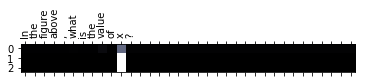

gen_rule value   x
conf 0.074030064
wordId 8
inc_over 1 0
pos_rules ['right triangles', 'six triangles']
line The figure above shows six right triangles .
tempQ six


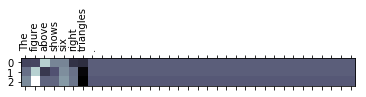

gen_rule six   figure
conf 0.02873209
wordId 4
inc fp  0
inc_over 1 1
tempQ right


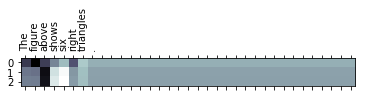

gen_rule right   six
conf 0.028851423
wordId 5
inc fp  1
inc_over 1 2
pos_rules ['value v']
line What is the value of v ?
tempQ value


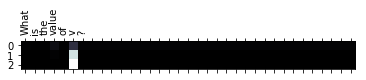

gen_rule value   v
conf 0.073719405
wordId 3
inc_over 2 2
pos_rules ['value v', 'quadrilateral PQRS']
line In quadrilateral PQRS above , what is the value of v ?
tempQ quadrilateral


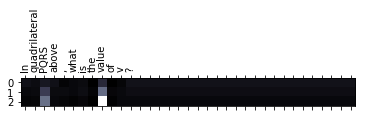

gen_rule quadrilateral   value
conf 0.035009965
wordId 1
inc fp  2
inc_over 2 3
tempQ value


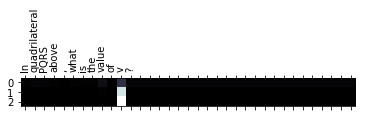

gen_rule value   v
conf 0.073724136
wordId 8
inc_over 3 3
pos_rules ['point O', 'line AB']
line In the figure above , point O lies on line AB .
tempQ point


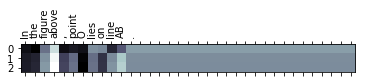

wordId 5
tempQ line


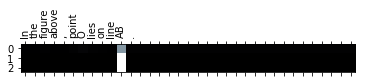

gen_rule line   AB
conf 0.074030735
wordId 9
inc_over 4 3
pos_rules ['value x']
line What is the value of x ?
tempQ value


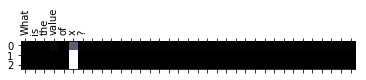

gen_rule value   x
conf 0.07402996
wordId 3
inc_over 5 3
pos_rules ['triangle ABC', 'angle BAC', 'point D']
line In triangle ABC above , the bisector of angle BAC is perpendicular to BC at point D .
tempQ triangle


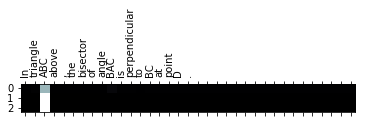

gen_rule triangle   ABC
conf 0.074030735
wordId 1
inc_over 6 3
tempQ angle


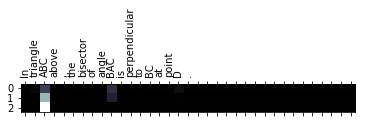

gen_rule angle   ABC
conf 0.07355767
wordId 8
inc fp  3
inc_over 6 4
tempQ point


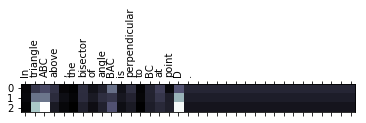

wordId 15
pos_rules ['angle BAC', 'measure BAC']
line If s holds and s holds , what is the measure of angle BAC ?
tempQ measure


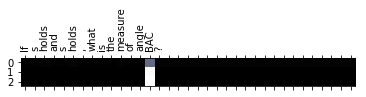

gen_rule measure   BAC
conf 0.07402315
wordId 10
inc_over 7 4
tempQ angle


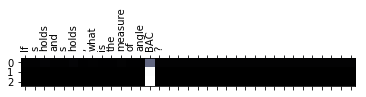

gen_rule angle   BAC
conf 0.0740258
wordId 12
inc_over 8 4
pos_rules ['three lines']
line In the figure above , three lines intersect at a point .
tempQ lines


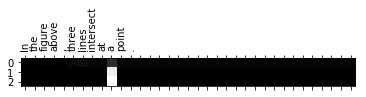

gen_rule lines   a
conf 0.07401339
wordId 6
inc fp  4
inc_over 8 5
tempQ point


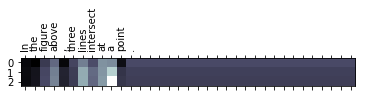

gen_rule point   a
conf 0.029836714
wordId 10
inc fp  5
inc_over 8 6
pos_rules ['value y']
line What is the value of y ?
tempQ value


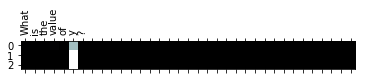

gen_rule value   y
conf 0.074029595
wordId 3
inc_over 9 6
pos_rules ['radius r']
line In the figure above , the circle has center P and radius r .
tempQ radius


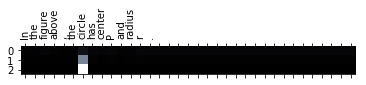

gen_rule radius   circle
conf 0.07330871
wordId 11
inc fp  6
inc_over 9 7
pos_rules ['Lines AB']
line Lines AB and AC are tangent to the circle .
tempQ Lines


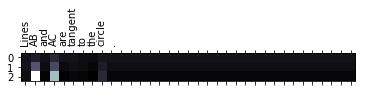

gen_rule Lines   AB
conf 0.034547854
wordId 0
inc_over 10 7
pos_rules ['measure PMC', 'measure MPC', 'segment AC', 'angle PMC', 'segment PA', 'length PA', 'angle MPC']
line If M is the midpoint of segment AC and the measure of angle PMC equals the measure of angle MPC , what is the length , in terms of r , of segment PA ?
tempQ segment


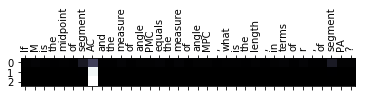

gen_rule segment   AC
conf 0.07401521
wordId 6
inc_over 11 7
tempQ measure


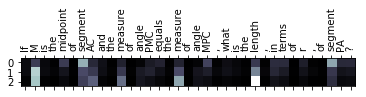

gen_rule measure   length
conf 0.034104127
wordId 10
inc fp  7
inc_over 11 8
tempQ angle


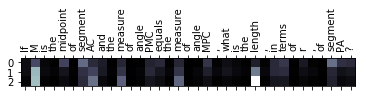

wordId 12
tempQ measure


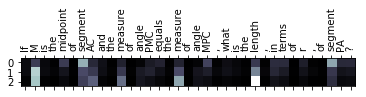

gen_rule measure   length
conf 0.034104127
wordId 16
tempQ angle


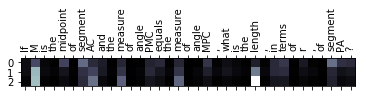

wordId 18
tempQ length


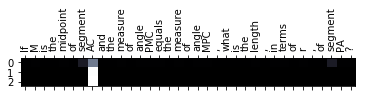

gen_rule length   AC
conf 0.07402094
wordId 24
inc fp  8
inc_over 11 9
tempQ segment


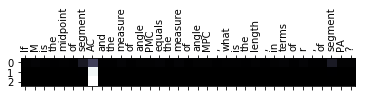

gen_rule segment   AC
conf 0.07401521
wordId 32
pos_rules ['lines l', 'point Q']
line In the figure above , lines l and k intersect at point Q .
tempQ lines


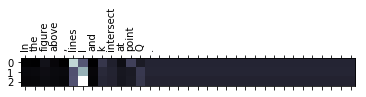

gen_rule lines   l
conf 0.03226947
wordId 5
inc_over 12 9
tempQ point


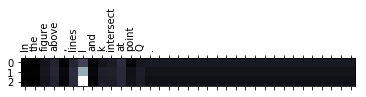

gen_rule point   l
conf 0.033283968
wordId 11
inc fp  9
inc_over 12 10
pos_rules ['value x']
line If s holds and s holds , what is the value of x ?
tempQ value


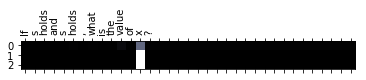

gen_rule value   x
conf 0.074030064
wordId 10
inc_over 13 10
pos_rules ['triangle ABC', 'diameter AC']
line In the figure above , triangle ABC is inscribed in the circle with center O and diameter AC .
tempQ triangle


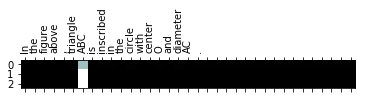

gen_rule triangle   ABC
conf 0.07403075
wordId 5
inc_over 14 10
tempQ diameter


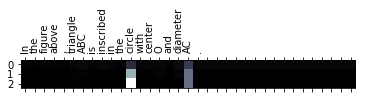

gen_rule diameter   circle
conf 0.052324798
wordId 16
inc fp  10
inc_over 14 11
pos_rules ['measure ABO', 'angle ABO']
line If s holds , what is the degree measure of angle ABO ?
tempQ measure


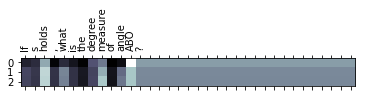

gen_rule measure   holds
conf 0.029056616
wordId 8
inc fp  11
inc_over 14 12
tempQ angle


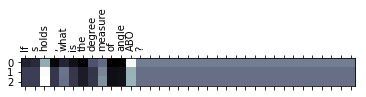

wordId 10
pos_rules ['line CD', 'line AB', 'line EF']
line In the figure above , line AB , line CD , and line EF intersect at P .
tempQ line


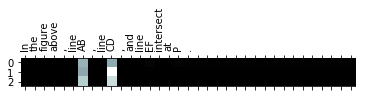

gen_rule line   CD
conf 0.046094283
wordId 5
inc_over 15 12
tempQ line


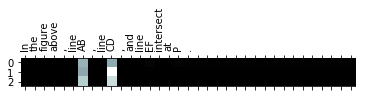

gen_rule line   CD
conf 0.046094283
wordId 8
tempQ line


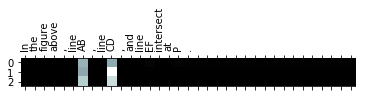

gen_rule line   CD
conf 0.046094283
wordId 12
pos_rules ['value x']
line If s holds , s holds , s holds , s holds , and s holds , what is the value of x ?
tempQ value


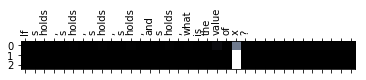

gen_rule value   x
conf 0.074030235
wordId 20
inc_over 16 12
pos_rules []
line In the figure above , PQRS is a rectangle .
tempQ rectangle


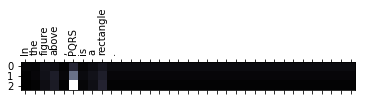

gen_rule rectangle   PQRS
conf 0.036235847
wordId 8
inc fp  12
inc_over 16 13
pos_rules ['area RST', 'triangle RST']
line The area of triangle RST is 7 and s holds .
tempQ area


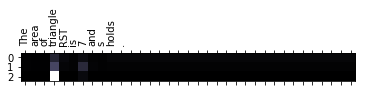

gen_rule area   triangle
conf 0.0656072
wordId 1
inc fp  13
inc_over 16 14
tempQ triangle


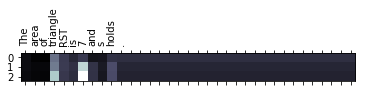

wordId 3
pos_rules ['area PQRS']
line What is the area of PQRS ?
tempQ area


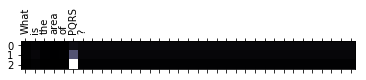

gen_rule area   PQRS
conf 0.0498319
wordId 3
inc_over 17 14
pos_rules ['point B', 'side AC']
line In the figure above , point B lies on side AC .
tempQ point


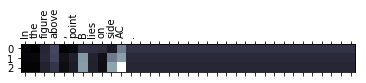

wordId 5
tempQ side


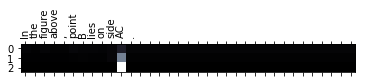

gen_rule side   AC
conf 0.07342719
wordId 9
inc_over 18 14
pos_rules ['value y']
line If s holds , what is one possible value of y ?
tempQ value


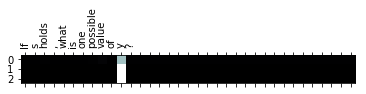

gen_rule value   y
conf 0.07402963
wordId 8
inc_over 19 14
pos_rules ['sides BD', 'rectangle ABDF']
line In rectangle ABDF above , C and E are midpoints of sides BD and DF , respectively .
tempQ rectangle


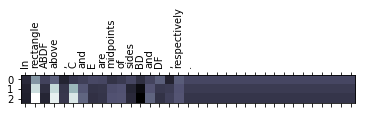

gen_rule rectangle   rectangle
conf 0.02964747
wordId 1
tempQ sides


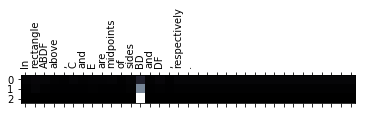

gen_rule sides   BD
conf 0.073521286
wordId 11
inc_over 20 14
pos_rules ['rectangle ABCD']
line In rectangle ABCD above , the area of the shaded region is given by v .
tempQ rectangle


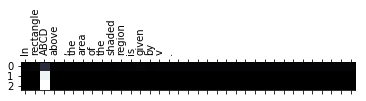

gen_rule rectangle   ABCD
conf 0.074029684
wordId 1
inc_over 21 14
tempQ area


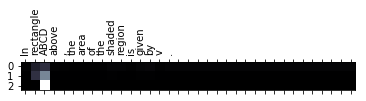

gen_rule area   ABCD
conf 0.07339251
wordId 6
inc fp  14
inc_over 21 15
pos_rules ['rectangle ABCD']
line If the area of the shaded region is v , what is the total area , to the nearest whole number , of the unshaded regions of rectangle ABCD ?
tempQ area


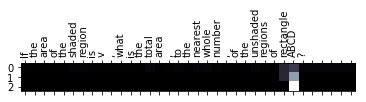

gen_rule area   ABCD
conf 0.07375759
wordId 2
inc fp  15
inc_over 21 16
tempQ area


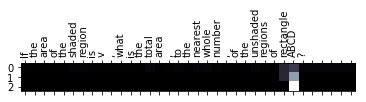

gen_rule area   ABCD
conf 0.07375759
wordId 14
tempQ rectangle


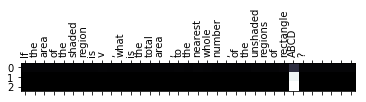

gen_rule rectangle   ABCD
conf 0.07402996
wordId 27
inc_over 22 16
pos_rules ['radii PA', 'Point P']
line Point P is the center of the large circle and PA and PB are radii .
tempQ Point


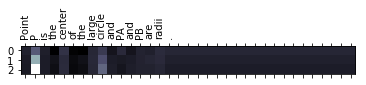

gen_rule Point   P
conf 0.030418562
wordId 0
inc_over 23 16
pos_rules ['radius circle', 'diameter AB']
line In the figure above , the circle with center O has radius 7 , AB is a diameter , and s holds .
tempQ radius


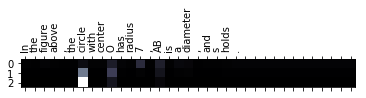

gen_rule radius   circle
conf 0.0628908
wordId 11
inc_over 24 16
tempQ diameter


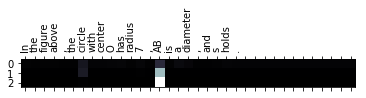

gen_rule diameter   AB
conf 0.07268672
wordId 17
inc_over 25 16
pos_rules ['area ABC']
line What is the area of triangle ABC ?
tempQ area


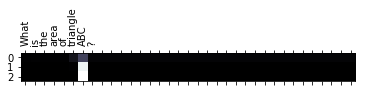

gen_rule area   ABC
conf 0.074028514
wordId 3
inc_over 26 16
tempQ triangle


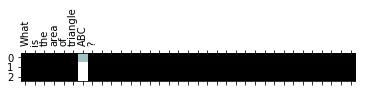

gen_rule triangle   ABC
conf 0.07403075
wordId 5
inc fp  16
inc_over 26 17
pos_rules ['parallel l', 'not parallel', 'lines l']
line In the figure above , lines l and m are not parallel .
tempQ lines


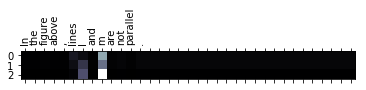

gen_rule lines   m
conf 0.049442988
wordId 5
inc fp  17
inc_over 26 18
tempQ not


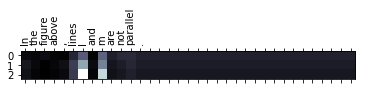

gen_rule not   l
conf 0.03218826
wordId 10
inc fp  18
inc_over 26 19
pos_rules ['true which']
line In the triangle above , which of the following must be true ?
tempQ triangle


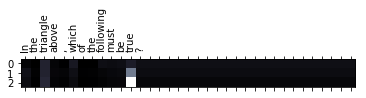

wordId 2
tempQ true


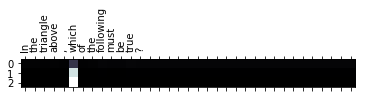

gen_rule true   which
conf 0.0738341
wordId 11
inc_over 27 19
pos_rules ['value x']
line In the figure above , what is the value of x ?
tempQ value


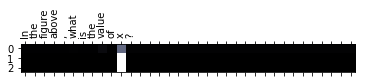

gen_rule value   x
conf 0.074030064
wordId 8
inc_over 28 19
pos_rules ['perimeter rectangle', 'area rectangle']
line The perimeter of the rectangle above is p and the area of the rectangle is 36 .
tempQ perimeter


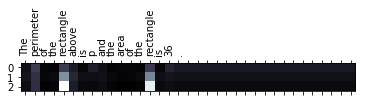

gen_rule perimeter   rectangle
conf 0.03417821
wordId 1
inc_over 29 19
tempQ rectangle


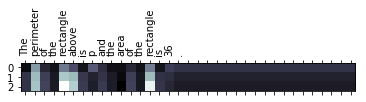

gen_rule rectangle   rectangle
conf 0.02978723
wordId 4
tempQ area


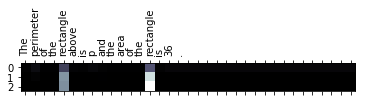

gen_rule area   rectangle
conf 0.050575677
wordId 10
inc_over 30 19
tempQ rectangle


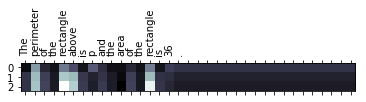

gen_rule rectangle   rectangle
conf 0.02978723
wordId 13
pos_rules ['value p', 'integers l']
line If l and w are integers , what is one possible value of p ?
tempQ value


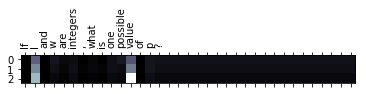

gen_rule value   value
conf 0.036959022
wordId 11
pos_rules ['value x']
line In the figure above , if the angle ( not shown ) where lines n and p intersect is twice as large as the angle ( also not shown ) where lines l and m intersect , what is the value of x ?
tempQ angle


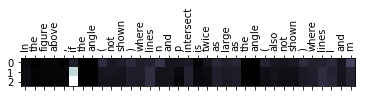

wordId 7
tempQ not


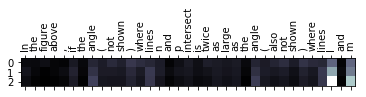

gen_rule not   l
conf 0.03240731
wordId 9
inc fp  19
inc_over 30 20
tempQ lines


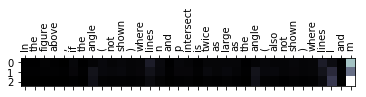

gen_rule lines   m
conf 0.045534186
wordId 13
inc fp  20
inc_over 30 21
tempQ twice


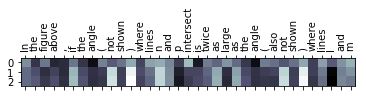

gen_rule twice   )
conf 0.029101983
wordId 19
tempQ angle


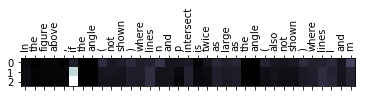

wordId 24
tempQ not


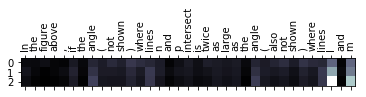

gen_rule not   l
conf 0.03240731
wordId 27
tempQ lines


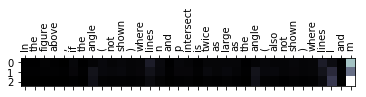

gen_rule lines   m
conf 0.045534186
wordId 31
pos_rules ['points A']
line In the figure above , points A and B lie on the circle with center O .
tempQ points


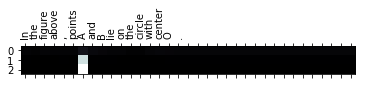

gen_rule points   A
conf 0.07402229
wordId 5
inc_over 31 21
pos_rules ['value z']
line If s holds , what is the value of z ?
tempQ value


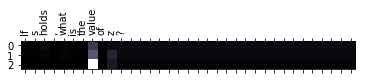

gen_rule value   value
conf 0.042988867
wordId 7
pos_rules ['value x', 'perimeter rectangle']
line If the perimeter of the rectangle above is 72 , what is the value of x ?
tempQ perimeter


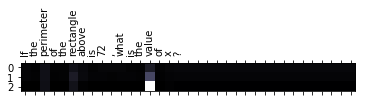

gen_rule perimeter   value
conf 0.05222687
wordId 2
inc fp  21
inc_over 31 22
tempQ rectangle


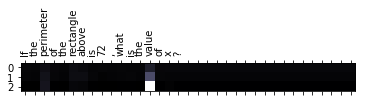

gen_rule rectangle   value
conf 0.04806967
wordId 5
inc fp  22
inc_over 31 23
tempQ value


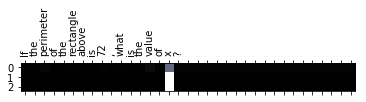

gen_rule value   x
conf 0.07402965
wordId 13
inc_over 32 23
pos_rules ['triangle ABC', 'length AB']
line In triangle ABC above , the length of AB is 3 , and D is the midpoint of AC .
tempQ triangle


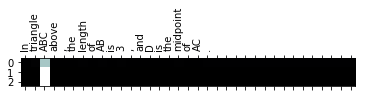

gen_rule triangle   ABC
conf 0.07403075
wordId 1
inc_over 33 23
tempQ length


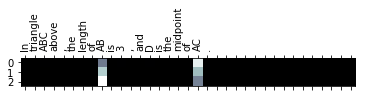

gen_rule length   AB
conf 0.051440444
wordId 6
inc_over 34 23
pos_rules ['length BC']
line What is the length of BC ?
tempQ length


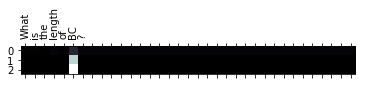

gen_rule length   BC
conf 0.07370965
wordId 3
inc_over 35 23
pos_rules ['area square', 'equilateral triangle']
line In the figure above , CDE is an equilateral triangle and ABCE is a square with an area of 1 .
tempQ equilateral


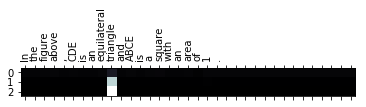

gen_rule equilateral   triangle
conf 0.07401697
wordId 8
inc_over 36 23
tempQ triangle


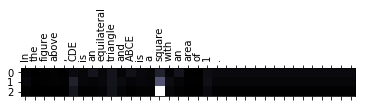

wordId 9
tempQ square


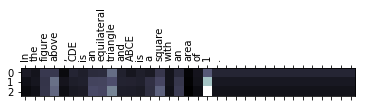

gen_rule square   1
conf 0.03129068
wordId 14
inc fp  23
inc_over 36 24
tempQ area


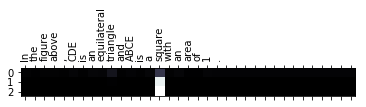

gen_rule area   square
conf 0.074014924
wordId 17
inc_over 37 24
pos_rules ['polygon ABCDE', 'perimeter ABCDE']
line What is the perimeter of polygon ABCDE ?
tempQ perimeter


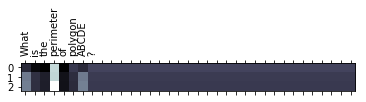

gen_rule perimeter   perimeter
conf 0.029899433
wordId 3
pos_rules ['area CAF', 'area CDEF', 'triangle CAF', 'rectangle CDEF', 'length AD', 'segment AD']
line In the figure above , if the area of triangle CAF is equal to the area of rectangle CDEF , what is the length of segment AD ?
tempQ area


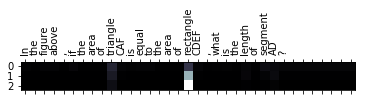

gen_rule area   rectangle
conf 0.06413395
wordId 7
inc fp  24
inc_over 37 25
tempQ triangle


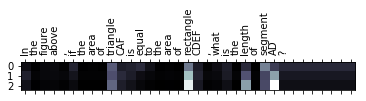

wordId 9
tempQ area


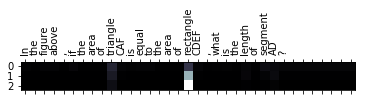

gen_rule area   rectangle
conf 0.06413395
wordId 15
tempQ rectangle


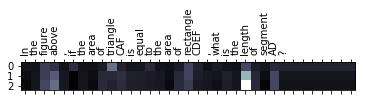

gen_rule rectangle   length
conf 0.031178348
wordId 17
inc fp  25
inc_over 37 26
tempQ length


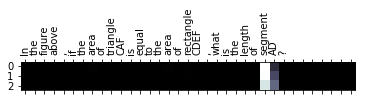

gen_rule length   segment
conf 0.05176106
wordId 23
inc fp  26
inc_over 37 27
tempQ segment


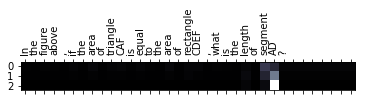

gen_rule segment   AD
conf 0.06557925
wordId 25
inc_over 38 27
pos_rules ['value z']
line If s holds and s holds in the figure above , what is the value of z ?
tempQ value


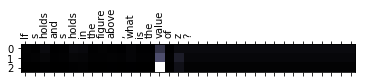

gen_rule value   value
conf 0.04860464
wordId 14
pos_rules ['triangle ABC', 'line AC', 'line AB']
line In triangle ABC above , s holds , E is the midpoint of line AB , and D is the midpoint of line AC .
tempQ triangle


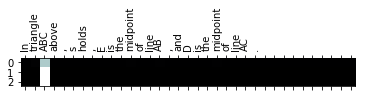

gen_rule triangle   ABC
conf 0.07403075
wordId 1
inc_over 39 27
tempQ line


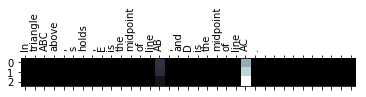

gen_rule line   AC
conf 0.065806754
wordId 13
inc_over 40 27
tempQ line


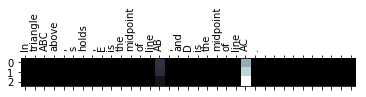

gen_rule line   AC
conf 0.065806754
wordId 22
pos_rules []
line If s holds and s holds , what is length BC ?
tempQ length


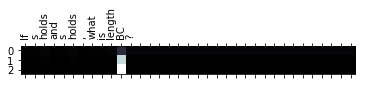

gen_rule length   BC
conf 0.07382487
wordId 9
inc fp  27
inc_over 40 28
pos_rules ['isosceles ABC', 'line AM', 'angle BCA', 'triangle ABC', 'angle BAC', 'line CM']
line In isosceles triangle ABC above , line AM and line CM are the angle bisectors of angle BAC and angle BCA .
tempQ isosceles


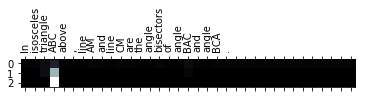

gen_rule isosceles   ABC
conf 0.07388246
wordId 1
inc_over 41 28
tempQ triangle


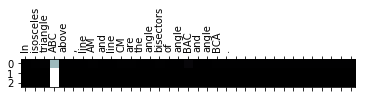

gen_rule triangle   ABC
conf 0.07403075
wordId 2
inc_over 42 28
tempQ line


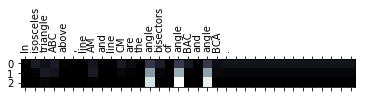

wordId 6
tempQ line


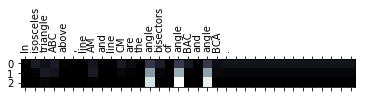

wordId 9
tempQ angle


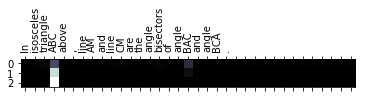

gen_rule angle   ABC
conf 0.07396659
wordId 13
inc fp  28
inc_over 42 29
tempQ angle


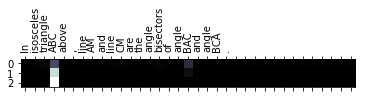

gen_rule angle   ABC
conf 0.07396659
wordId 16
tempQ angle


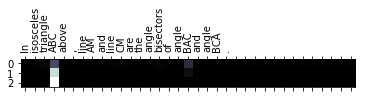

gen_rule angle   ABC
conf 0.07396659
wordId 19
pos_rules ['measure AMC', 'angle AMC']
line What is the measure of angle AMC ?
tempQ measure


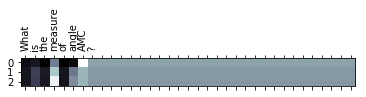

gen_rule measure   measure
conf 0.029116467
wordId 3
tempQ angle


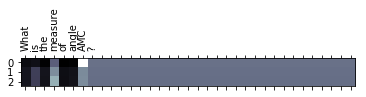

wordId 5
pos_rules ['congruent triangles', 'equilateral triangles']
line The figure above is composed of 25 small triangles that are congruent and equilateral .
tempQ equilateral


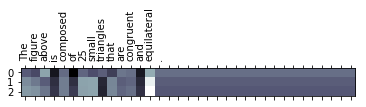

gen_rule equilateral   equilateral
conf 0.029095856
wordId 13
pos_rules ['area AFK', 'triangle DFH', 'area DFH', 'triangle AFK']
line If the area of triangle DFH is 10 , what is the area of triangle AFK ?
tempQ area


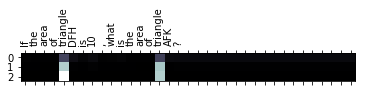

gen_rule area   triangle
conf 0.047696363
wordId 2
inc fp  29
inc_over 42 30
tempQ triangle


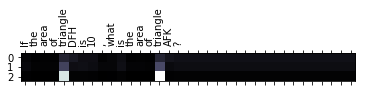

wordId 4
tempQ area


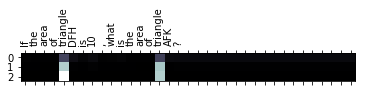

gen_rule area   triangle
conf 0.047696363
wordId 12
tempQ triangle


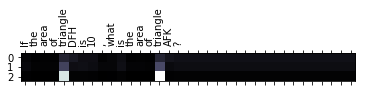

wordId 14
pos_rules []
line In the figure above , a shaded polygon which has equal sides and equal angles is partially covered with a sheet of blank paper .
tempQ sides


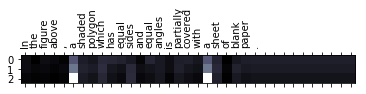

gen_rule sides   a
conf 0.033092007
wordId 11
inc fp  30
inc_over 42 31
tempQ angles


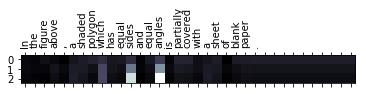

gen_rule angles   angles
conf 0.033141144
wordId 14
pos_rules []
line If s holds , how many sides does the polygon have ?
tempQ sides


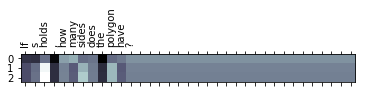

gen_rule sides   holds
conf 0.029172532
wordId 6
inc fp  31
inc_over 42 32
pos_rules ['point B', 'line AC']
line In the figure above , point B lies on line AC .
tempQ point


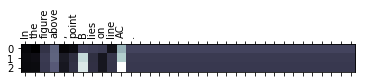

wordId 5
tempQ line


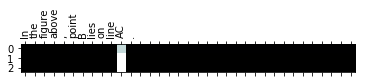

gen_rule line   AC
conf 0.07403075
wordId 9
inc_over 43 32
pos_rules ['value x', 'integers integers']
line If x and y are integers , which of the following is a possible value of x ?
tempQ value


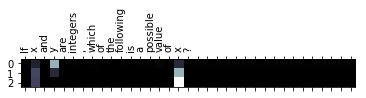

gen_rule value   x
conf 0.056359764
wordId 14
inc_over 44 32
pos_rules ['Point O']
line Point O is the center of both circles in the figure above .
tempQ Point


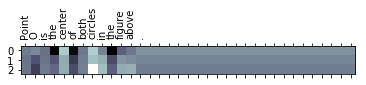

wordId 0
pos_rules ['circumference circle', 'length arc']
line If the circumference of the large circle is 36 and the radius of the small circle is half of the radius of the large circle , what is the length of the darkened arc ?
tempQ radius


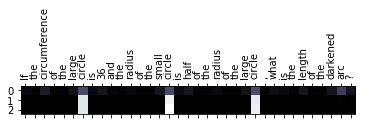

gen_rule radius   circle
conf 0.039181963
wordId 11
inc fp  32
inc_over 44 33
tempQ radius


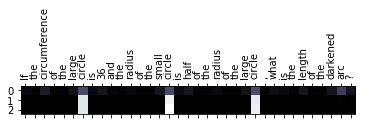

gen_rule radius   circle
conf 0.039181963
wordId 20
tempQ length


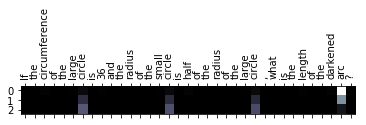

gen_rule length   circle
conf 0.038187936
wordId 29
inc fp  33
inc_over 44 34
tempQ arc


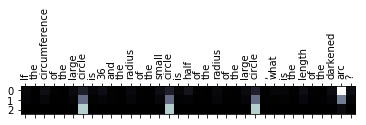

gen_rule arc   circle
conf 0.03826093
wordId 33
inc fp  34
inc_over 44 35
pos_rules []
line In the figure above , P , Q , and R lie on the same line .
tempQ line


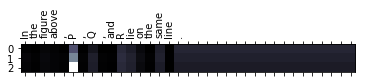

gen_rule line   P
conf 0.034261122
wordId 15
inc fp  35
inc_over 44 36
pos_rules []
line P is the center of the larger circle , and Q is the center of the smaller circle .
pos_rules ['radius circle', 'radius circle']
line If the radius of the larger circle is 4 , what is the radius of the smaller circle ?
tempQ radius


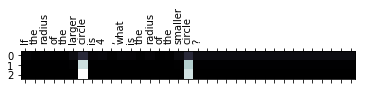

gen_rule radius   circle
conf 0.046730038
wordId 2
inc_over 45 36
tempQ radius


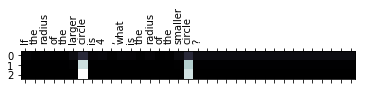

gen_rule radius   circle
conf 0.046730038
wordId 13
pos_rules ['centers R']
line The two semicircles in the figure above have centers R and S , respectively .
tempQ two


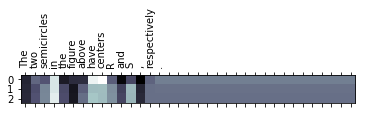

gen_rule two   in
conf 0.02911462
wordId 1
inc fp  36
inc_over 45 37
pos_rules []
line If s holds , what is the total length of the darkened curve ?
tempQ length


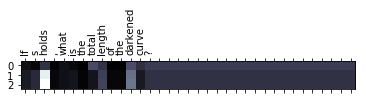

gen_rule length   holds
conf 0.03146804
wordId 8
inc fp  37
inc_over 45 38
pos_rules []
line In the figure above , s holds .
pos_rules []
line Which of the following must equal 180 ?
pos_rules ['three lines']
line In the figure above , three lines intersect at a point .
tempQ lines


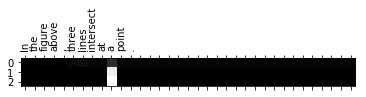

gen_rule lines   a
conf 0.07401339
wordId 6
inc fp  38
inc_over 45 39
tempQ point


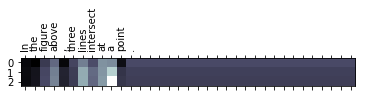

gen_rule point   a
conf 0.029836714
wordId 10
inc fp  39
inc_over 45 40
pos_rules ['value a']
line If s holds and s holds , what is the value of a ?
tempQ value


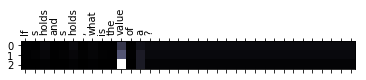

gen_rule value   value
conf 0.044410523
wordId 10
pos_rules ['length AE', 'triangles ABC', 'equilateral ABC', 'line_segment AE']
line In the figure above , triangles ABC and CDE are equilateral and line segment AE has length 25 .
tempQ equilateral


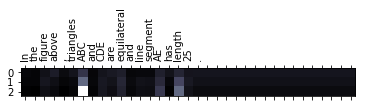

gen_rule equilateral   ABC
conf 0.03304498
wordId 10
inc_over 46 40
tempQ line


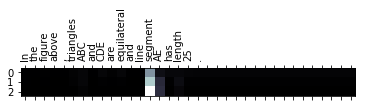

wordId 12
tempQ length


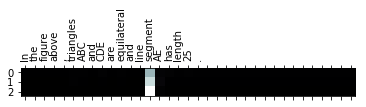

gen_rule length   segment
conf 0.07145218
wordId 16
inc fp  40
inc_over 46 41
pos_rules ['perimeters triangles', 'sum perimeters', 'two triangles']
line What is the sum of the perimeters of the two triangles ?
tempQ sum


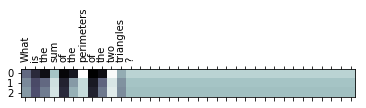

gen_rule sum   two
conf 0.028767139
wordId 3
inc fp  41
inc_over 46 42
tempQ two


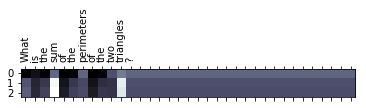

gen_rule two   sum
conf 0.029369352
wordId 9
inc fp  42
inc_over 46 43
pos_rules ['greatest which']
line In the figure above , which of the following is the greatest ?
pos_rules []
line In the figure above , if s holds and s holds , then s is true
tempQ true


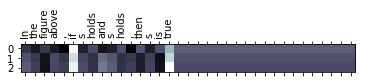

gen_rule true   true
conf 0.02963056
wordId 15
pos_rules ['triangle PQR']
line In triangle PQR above , s holds .
tempQ triangle


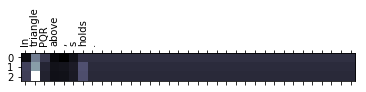

wordId 1
pos_rules ['true Which']
line Which of the following must be true ?
tempQ true


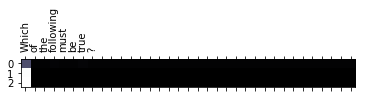

gen_rule true   Which
conf 0.07402973
wordId 6
pos_rules ['perimeter trapezoid']
line What is the perimeter of the trapezoid above ?
tempQ perimeter


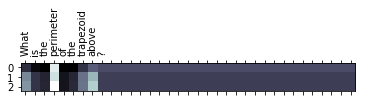

gen_rule perimeter   perimeter
conf 0.029734947
wordId 3
tempQ trapezoid


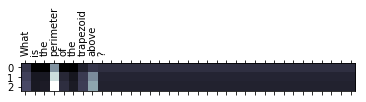

gen_rule trapezoid   perimeter
conf 0.029720167
wordId 6
inc fp  43
inc_over 46 44
pos_rules []
line In the figure above , the smaller circles each have radius 3 .
tempQ radius


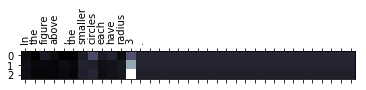

gen_rule radius   3
conf 0.03260593
wordId 10
inc fp  44
inc_over 46 45
pos_rules ['points A', 'point B']
line They are tangent to the larger circle at points A and C , and are tangent to each other at point B , which is the center of the larger circle .
tempQ points


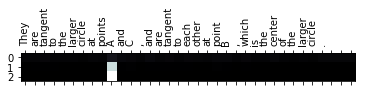

gen_rule points   A
conf 0.0740093
wordId 8
inc_over 47 45
tempQ point


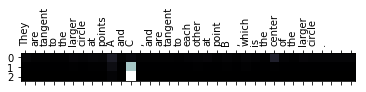

gen_rule point   C
conf 0.071054325
wordId 20
inc fp  45
inc_over 47 46
pos_rules []
line What is the perimeter of the shaded region ?
tempQ perimeter


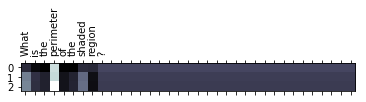

gen_rule perimeter   perimeter
conf 0.029900989
wordId 3
pos_rules []
line In the figure above , s holds and s holds .
pos_rules ['line AB', 'line CP', 'Point P', 'line AB']
line Point P lies on line AB between A and B such that line CP is perpendicular to line AB .
tempQ Point


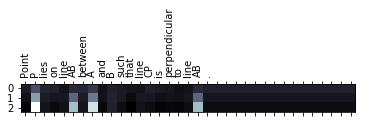

gen_rule Point   P
conf 0.030661842
wordId 0
inc_over 48 46
tempQ line


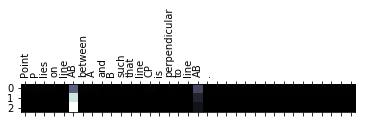

gen_rule line   AB
conf 0.066412605
wordId 4
inc_over 49 46
tempQ line


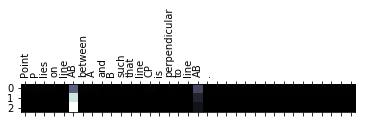

gen_rule line   AB
conf 0.066412605
wordId 12
tempQ line


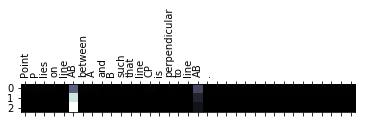

gen_rule line   AB
conf 0.066412605
wordId 17
pos_rules ['length CP', 'line CP']
line Which of the following could be the length of line CP ?
tempQ length


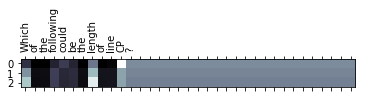

gen_rule length   length
conf 0.029398821
wordId 7
tempQ line


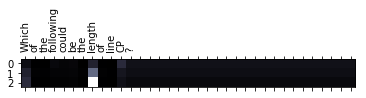

wordId 9
pos_rules ['five lines']
line The figure above shows five lines .
tempQ lines


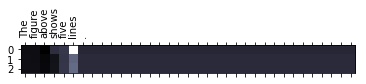

gen_rule lines   lines
conf 0.029423028
wordId 5
pos_rules ['not equal']
line If s holds , which of the following is not equal to 90 ?
tempQ not


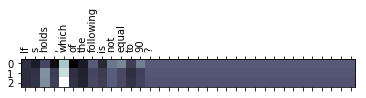

gen_rule not   which
conf 0.029705897
wordId 9
inc fp  46
inc_over 49 47
pos_rules ['length sides', 'three squares']
line The figure above shows three squares with sides of length 5 , 7 , and x , respectively .
tempQ sides


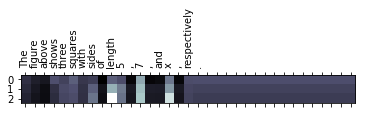

gen_rule sides   length
conf 0.030128948
wordId 7
inc fp  47
inc_over 49 48
tempQ length


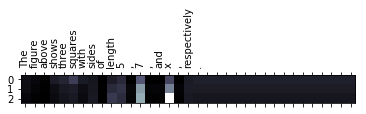

gen_rule length   x
conf 0.03381748
wordId 9
inc fp  48
inc_over 49 49
pos_rules ['value x', 'line l']
line If A , B , and C lie on line l , what is the value of x ?
tempQ line


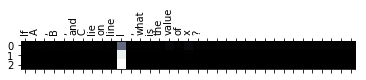

gen_rule line   l
conf 0.073909074
wordId 9
inc_over 50 49
tempQ value


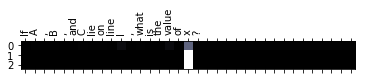

gen_rule value   x
conf 0.07403001
wordId 15
inc_over 51 49
pos_rules ['value y']
line In the figure above , what is the value of y ?
tempQ value


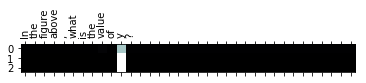

gen_rule value   y
conf 0.074029714
wordId 8
inc_over 52 49
pos_rules ['regular hexagon', 'center O', 'point O']
line In the figure above , ABCDEF is a regular hexagon , and its center is point O .
tempQ point


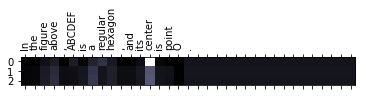

wordId 15
pos_rules ['value x']
line What is the value of x ?
tempQ value


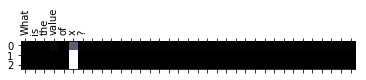

gen_rule value   x
conf 0.07402996
wordId 3
inc_over 53 49
pos_rules ['area circle']
line The circle above has an area of v and is divided into 8 congruent regions .
tempQ area


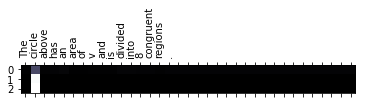

gen_rule area   circle
conf 0.074029215
wordId 5
inc_over 54 49
pos_rules []
line What is the perimeter of these regions ?
tempQ perimeter


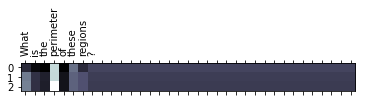

gen_rule perimeter   perimeter
conf 0.029856257
wordId 3
pos_rules ['point P', 'line l']
line In the figure above , point P is on line l .
tempQ point


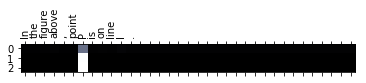

gen_rule point   P
conf 0.07402988
wordId 5
inc_over 55 49
tempQ line


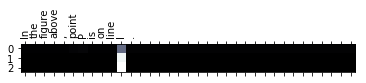

gen_rule line   l
conf 0.07397006
wordId 9
inc_over 56 49
pos_rules ['value x']
line What is the value of x ?
tempQ value


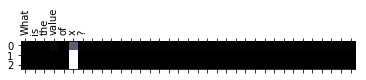

gen_rule value   x
conf 0.07402996
wordId 3
inc_over 57 49
pos_rules ['triangle ABC', 'side AC', 'line l']
line In the figure above , side AC of triangle ABC is on line l .
tempQ side


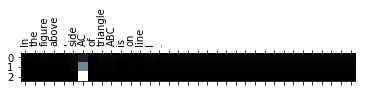

gen_rule side   AC
conf 0.07343716
wordId 5
inc_over 58 49
tempQ triangle


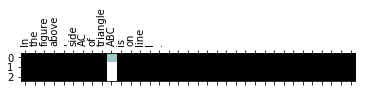

gen_rule triangle   ABC
conf 0.07403075
wordId 8
inc_over 59 49
tempQ line


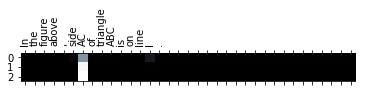

gen_rule line   AC
conf 0.074010454
wordId 12
inc fp  49
inc_over 59 50
pos_rules []
line What is x in terms of k ?
pos_rules ['measure CBA', 'angle CBA']
line What is the measure of angle CBA ?
tempQ measure


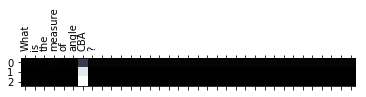

gen_rule measure   CBA
conf 0.07390137
wordId 3
inc_over 60 50
tempQ angle


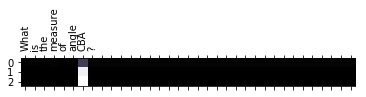

gen_rule angle   CBA
conf 0.07396128
wordId 5
inc_over 61 50
61 50 0 84 0.54954954955 0.420689655172 0.4765625


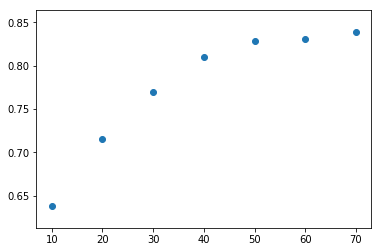

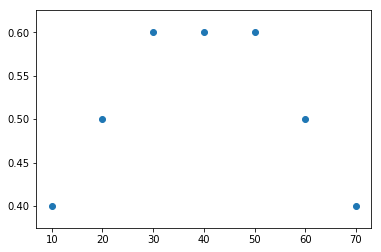

In [0]:
tf.set_random_seed(random_state)
config_results = open("config_results.txt", "w+")
configs = list()
epochss = [70,80,100]
lrs = [0.001, 0.005,0.01]
batch_sizes = [10,20,30,50]
embedding_sizes = [30,40,50]
hops = [3,4,5]
max_grad_norm = 40.0

for eps in epochss:
    for lr in lrs:
        for bs in batch_sizes:
            for es in embedding_sizes:
                for hp in hops:
                    configs.append([eps, lr, bs, es, hp, max_grad_norm])

configs = list()
configs.append([70,	0.001,	30,	50,	3, 40.0])
# configs.append([70,	0.001,	30,	50,	3, 40.0])
# configs.append([70,	0.001,	30,	50,	3, 40.0])
# configs.append([70,	0.001,	30,	50,	3, 40.0])
# configs.append([70,	0.001,	30,	50,	3, 40.0])
for config in configs:
    epochs, learning_rate,batch_size, embedding_size, hops, max_grad_norm = config
    config_results.write(str(epochs)+','+str(learning_rate)+','+str(batch_size)+
                         ','+ str(embedding_size)+','+ str(hops)+',')
    batches = zip(range(0, n_train - batch_size, batch_size), range(batch_size, n_train, batch_size))
    batches = [(start, end) for start, end in batches]

    batches2 = zip(range(0, n_train - batch_size, batch_size), range(batch_size, n_train, batch_size))
    batches2 = [(start, end) for start, end in batches]


    model = None
    val_acc_list = list()
    train_acc_list = list()
    ep_list = list()

    val_acc_list2 = list()
    train_acc_list2 = list()
    ep_list2 = list()
    lr_list = list()

    tf.reset_default_graph()
    sess2 = tf.Session()

    # with tf.Session() as sess:
    print (epochs, learning_rate,batch_size, embedding_size, hops)
    model2 = MemN2N(batch_size, vocab_size, sentence_size, memory_size, embedding_size, session=sess2,
                    hops=hops, max_grad_norm=max_grad_norm)

    train_acc2 = 0.0
    # multiple word
    for t in range(1, epochs + 1):
        # Stepped learning rate
        #     if t - 1 <= anneal_stop_epoch:
        #         anneal = 2.0 ** ((t - 1) // anneal_rate)
        #     else:
        #         anneal = 2.0 ** (anneal_stop_epoch // anneal_rate)
        anneal = 1.0
        lr = learning_rate / anneal

        np.random.shuffle(batches)
        total_cost2 = 0.0

        for start, end in batches:
            s2 = trainS2[start:end]
            q2 = trainQ2[start:end]
            a2 = trainA2[start:end]

            #         print('s2', s2)
            cost_t2 = model2.batch_fit(s2, q2, a2, lr)
            total_cost2 += cost_t2

        if t % evaluation_interval == 0:
            train_preds2 = []
            for start in range(0, n_train, batch_size):
                end = start + batch_size
                s2 = trainS2[start:end]
                q2 = trainQ2[start:end]
                #             pred2 = model2.predict(s, q)

                if (len(s2) != batch_size):
                    continue

                pred2, att = model2.predict(s2, q2)
                train_preds2 += list(pred2)
            # print('train_preds\n',train_preds[:5] )
            #             print('train_labels\n',train_labels[:5])

            train_acc2 = metrics.accuracy_score(np.array(train_preds2), train_labels2[:len(train_preds2)])
            train_acc_list2.append(train_acc2)
            test_preds2, att = model2.predict(testS2, testQ2)
            val_acc2 = metrics.accuracy_score(test_preds2, test_labels2)
            val_acc_list2.append(val_acc2)
            ep_list2.append(t)

    test_preds2, att = model2.predict(testS2, testQ2)
    test_acc2 = metrics.accuracy_score(test_preds2, test_labels2)
    print("Testing Accuracy:", train_acc2, test_acc2)

    tp, fp, tn, fn = evaluate(evaluate_data, keyword_dict)
    precison = 1.0 * tp / (tp + fp)
    recall = 1.0 * tp / (tp + fn)
    f1Score = 2.0 * precison * recall / (precison + recall)

    print(tp, fp, tn, fn, precison, recall, f1Score)
    config_results.write(str(tp)+','+str(fp)+','+str(fn)+','+str(precison)+','+str(recall)+','+str(f1Score))
    config_results.write('\n')
    mpl.pyplot.scatter(ep_list2, train_acc_list2)
    mpl.pyplot.show()

    mpl.pyplot.scatter(ep_list2, val_acc_list2)
    mpl.pyplot.show()




In [0]:
print(tp, fp, tn, fn, precison, recall, f1Score)

66 45 0 79 0.594594594595 0.455172413793 0.515625


In [0]:
print(tp, fp, tn, fn, precison, recall, f1Score)

68 50 0 77 0.576271186441 0.468965517241 0.51711026616


In [0]:
config_results.close()

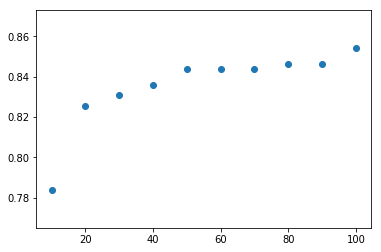

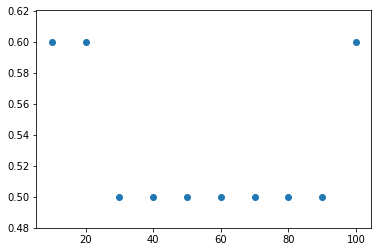

In [0]:
mpl.pyplot.scatter(ep_list2,train_acc_list2)
mpl.pyplot.show()

mpl.pyplot.scatter(ep_list2,val_acc_list2)
mpl.pyplot.show()

  


In [0]:
log_info =1
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_attention(in_seq, out_seq, attentions):
    """ From http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html"""

    out_seq = out_seq
    attentions = attentions
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
#     fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([' '] + [str(x) for x in in_seq], rotation=90)
    ax.set_yticklabels([' '] + [str(x) for x in out_seq])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

pos_rules ['value x']
line In the figure above , what is the value of x ?
tempQ value


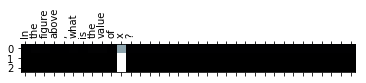

gen_rule value   x
conf 0.074030735
wordId 8
inc_over 1 0
pos_rules ['right triangles', 'six triangles']
line The figure above shows six right triangles .
tempQ six


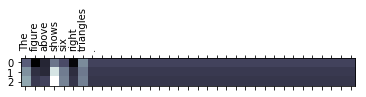

gen_rule six   shows
conf 0.028762873
wordId 4
inc fp  0
inc_over 1 1
tempQ right


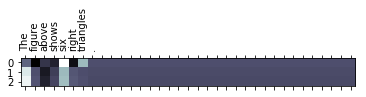

gen_rule right   The
conf 0.028963208
wordId 5
pos_rules ['value v']
line What is the value of v ?
tempQ value


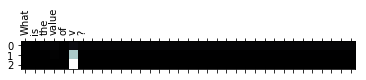

gen_rule value   v
conf 0.073383115
wordId 3
inc_over 2 1
pos_rules ['value v', 'quadrilateral PQRS']
line In quadrilateral PQRS above , what is the value of v ?
tempQ quadrilateral


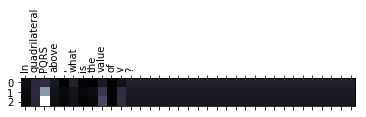

gen_rule quadrilateral   PQRS
conf 0.03258145
wordId 1
inc_over 3 1
tempQ value


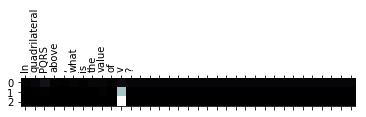

gen_rule value   v
conf 0.0732864
wordId 8
inc_over 4 1
pos_rules ['point O', 'line AB']
line In the figure above , point O lies on line AB .
tempQ point


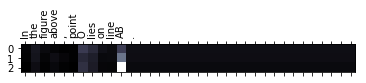

wordId 5
tempQ line


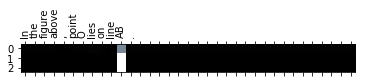

gen_rule line   AB
conf 0.074030735
wordId 9
inc_over 5 1
pos_rules ['value x']
line What is the value of x ?
tempQ value


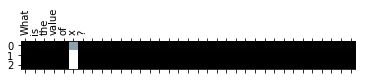

gen_rule value   x
conf 0.074030735
wordId 3
inc_over 6 1
pos_rules ['triangle ABC', 'angle BAC', 'point D']
line In triangle ABC above , the bisector of angle BAC is perpendicular to BC at point D .
tempQ triangle


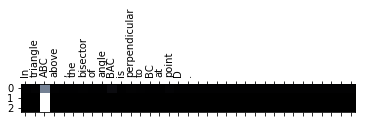

gen_rule triangle   ABC
conf 0.07403036
wordId 1
inc_over 7 1
tempQ angle


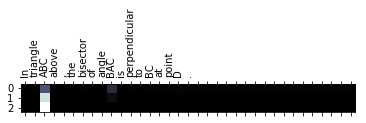

gen_rule angle   ABC
conf 0.073942915
wordId 8
inc fp  1
inc_over 7 2
tempQ point


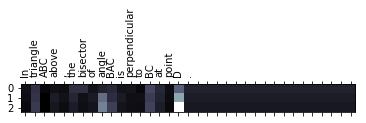

gen_rule point   D
conf 0.03240971
wordId 15
inc_over 8 2
pos_rules ['angle BAC', 'measure BAC']
line If s holds and s holds , what is the measure of angle BAC ?
tempQ measure


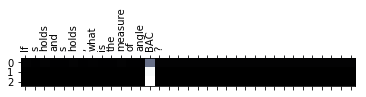

gen_rule measure   BAC
conf 0.07401192
wordId 10
inc_over 9 2
tempQ angle


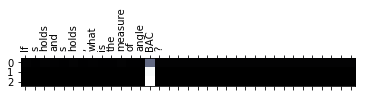

gen_rule angle   BAC
conf 0.07401404
wordId 12
inc_over 10 2
pos_rules ['three lines']
line In the figure above , three lines intersect at a point .
tempQ lines


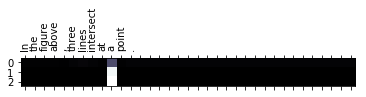

gen_rule lines   a
conf 0.07401839
wordId 6
inc fp  2
inc_over 10 3
tempQ point


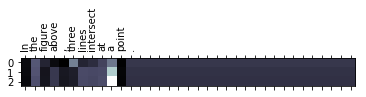

gen_rule point   a
conf 0.029961666
wordId 10
inc fp  3
inc_over 10 4
pos_rules ['value y']
line What is the value of y ?
tempQ value


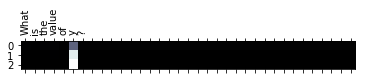

gen_rule value   y
conf 0.073934525
wordId 3
inc_over 11 4
pos_rules ['radius r']
line In the figure above , the circle has center P and radius r .
tempQ radius


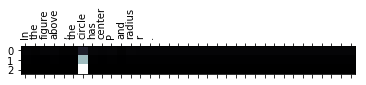

gen_rule radius   circle
conf 0.073850766
wordId 11
inc fp  4
inc_over 11 5
pos_rules ['Lines AB']
line Lines AB and AC are tangent to the circle .
tempQ Lines


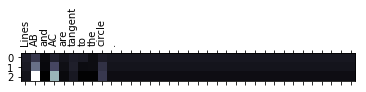

gen_rule Lines   AB
conf 0.030962426
wordId 0
inc_over 12 5
pos_rules ['measure PMC', 'measure MPC', 'segment AC', 'angle PMC', 'segment PA', 'length PA', 'angle MPC']
line If M is the midpoint of segment AC and the measure of angle PMC equals the measure of angle MPC , what is the length , in terms of r , of segment PA ?
tempQ segment


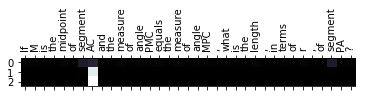

gen_rule segment   AC
conf 0.07398489
wordId 6
inc_over 13 5
tempQ measure


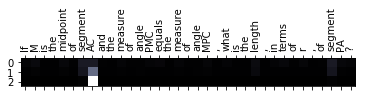

gen_rule measure   AC
conf 0.07091971
wordId 10
inc fp  5
inc_over 13 6
tempQ angle


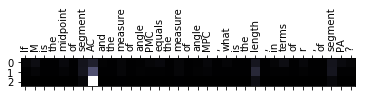

wordId 12
tempQ measure


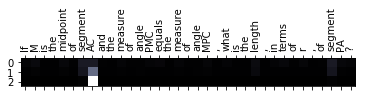

gen_rule measure   AC
conf 0.07091971
wordId 16
tempQ angle


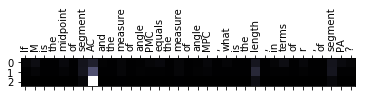

wordId 18
tempQ length


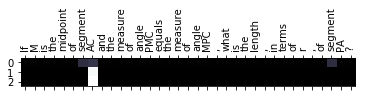

gen_rule length   AC
conf 0.07401807
wordId 24
inc fp  6
inc_over 13 7
tempQ segment


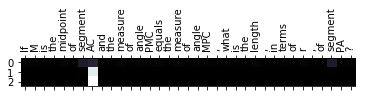

gen_rule segment   AC
conf 0.07398489
wordId 32
pos_rules ['lines l', 'point Q']
line In the figure above , lines l and k intersect at point Q .
tempQ lines


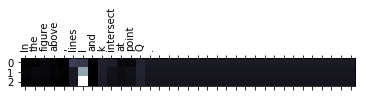

gen_rule lines   l
conf 0.03423926
wordId 5
inc_over 14 7
tempQ point


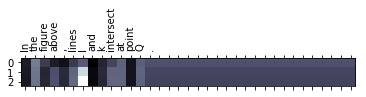

gen_rule point   l
conf 0.029739257
wordId 11
inc fp  7
inc_over 14 8
pos_rules ['value x']
line If s holds and s holds , what is the value of x ?
tempQ value


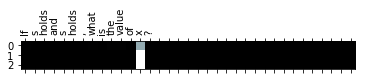

gen_rule value   x
conf 0.074030735
wordId 10
inc_over 15 8
pos_rules ['triangle ABC', 'diameter AC']
line In the figure above , triangle ABC is inscribed in the circle with center O and diameter AC .
tempQ triangle


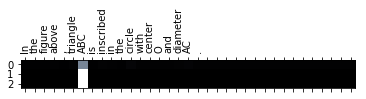

gen_rule triangle   ABC
conf 0.07403061
wordId 5
inc_over 16 8
tempQ diameter


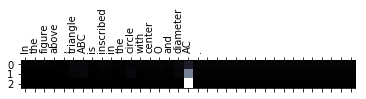

gen_rule diameter   AC
conf 0.07343092
wordId 16
inc_over 17 8
pos_rules ['measure ABO', 'angle ABO']
line If s holds , what is the degree measure of angle ABO ?
tempQ measure


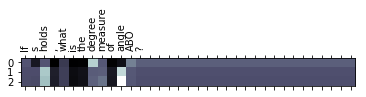

gen_rule measure   angle
conf 0.029946426
wordId 8
inc fp  8
inc_over 17 9
tempQ angle


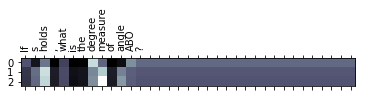

wordId 10
pos_rules ['line CD', 'line AB', 'line EF']
line In the figure above , line AB , line CD , and line EF intersect at P .
tempQ line


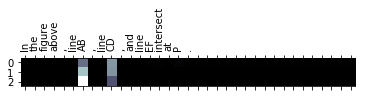

gen_rule line   AB
conf 0.054747123
wordId 5
inc_over 18 9
tempQ line


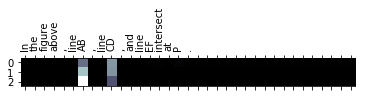

gen_rule line   AB
conf 0.054747123
wordId 8
tempQ line


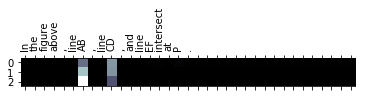

gen_rule line   AB
conf 0.054747123
wordId 12
pos_rules ['value x']
line If s holds , s holds , s holds , s holds , and s holds , what is the value of x ?
tempQ value


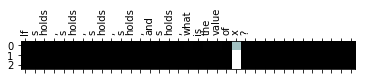

gen_rule value   x
conf 0.07403075
wordId 20
inc_over 19 9
pos_rules []
line In the figure above , PQRS is a rectangle .
tempQ rectangle


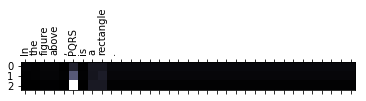

gen_rule rectangle   PQRS
conf 0.045494948
wordId 8
inc fp  9
inc_over 19 10
pos_rules ['area RST', 'triangle RST']
line The area of triangle RST is 7 and s holds .
tempQ area


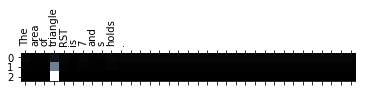

gen_rule area   triangle
conf 0.073093764
wordId 1
inc fp  10
inc_over 19 11
tempQ triangle


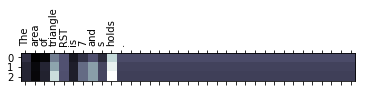

wordId 3
pos_rules ['area PQRS']
line What is the area of PQRS ?
tempQ area


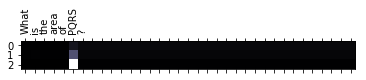

gen_rule area   PQRS
conf 0.053093106
wordId 3
inc_over 20 11
pos_rules ['point B', 'side AC']
line In the figure above , point B lies on side AC .
tempQ point


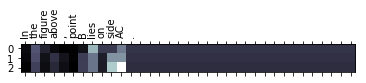

wordId 5
tempQ side


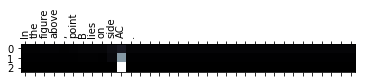

gen_rule side   AC
conf 0.07358408
wordId 9
inc_over 21 11
pos_rules ['value y']
line If s holds , what is one possible value of y ?
tempQ value


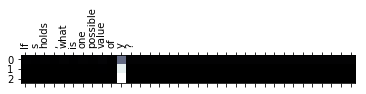

gen_rule value   y
conf 0.07394477
wordId 8
inc_over 22 11
pos_rules ['sides BD', 'rectangle ABDF']
line In rectangle ABDF above , C and E are midpoints of sides BD and DF , respectively .
tempQ rectangle


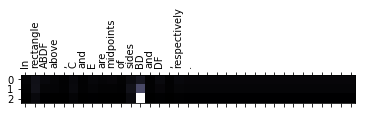

wordId 1
tempQ sides


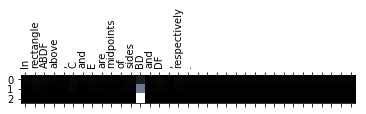

gen_rule sides   BD
conf 0.0727711
wordId 11
inc_over 23 11
pos_rules ['rectangle ABCD']
line In rectangle ABCD above , the area of the shaded region is given by v .
tempQ rectangle


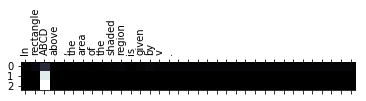

gen_rule rectangle   ABCD
conf 0.07402536
wordId 1
inc_over 24 11
tempQ area


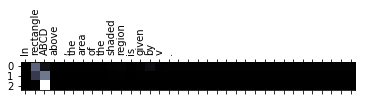

gen_rule area   ABCD
conf 0.07236478
wordId 6
inc fp  11
inc_over 24 12
pos_rules ['rectangle ABCD']
line If the area of the shaded region is v , what is the total area , to the nearest whole number , of the unshaded regions of rectangle ABCD ?
tempQ area


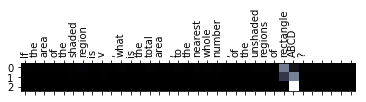

gen_rule area   ABCD
conf 0.072833
wordId 2
inc fp  12
inc_over 24 13
tempQ area


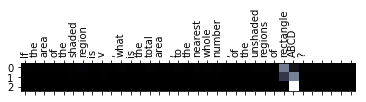

gen_rule area   ABCD
conf 0.072833
wordId 14
tempQ rectangle


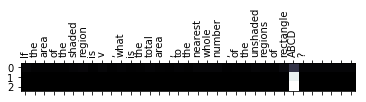

gen_rule rectangle   ABCD
conf 0.07402729
wordId 27
inc_over 25 13
pos_rules ['radii PA', 'Point P']
line Point P is the center of the large circle and PA and PB are radii .
tempQ Point


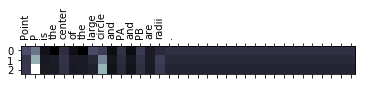

gen_rule Point   P
conf 0.029642997
wordId 0
inc_over 26 13
pos_rules ['radius circle', 'diameter AB']
line In the figure above , the circle with center O has radius 7 , AB is a diameter , and s holds .
tempQ radius


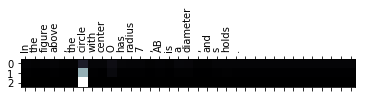

gen_rule radius   circle
conf 0.07357971
wordId 11
inc_over 27 13
tempQ diameter


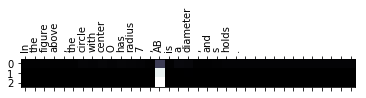

gen_rule diameter   AB
conf 0.07402667
wordId 17
inc_over 28 13
pos_rules ['area ABC']
line What is the area of triangle ABC ?
tempQ area


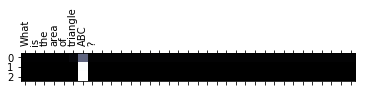

gen_rule area   ABC
conf 0.074030474
wordId 3
inc_over 29 13
tempQ triangle


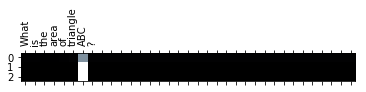

gen_rule triangle   ABC
conf 0.07403075
wordId 5
inc fp  13
inc_over 29 14
pos_rules ['parallel l', 'not parallel', 'lines l']
line In the figure above , lines l and m are not parallel .
tempQ lines


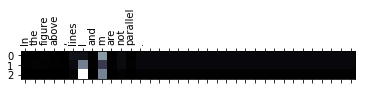

gen_rule lines   l
conf 0.04411671
wordId 5
inc_over 30 14
tempQ not


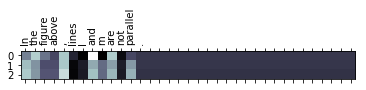

gen_rule not   ,
conf 0.029284058
wordId 10
pos_rules ['true which']
line In the triangle above , which of the following must be true ?
tempQ triangle


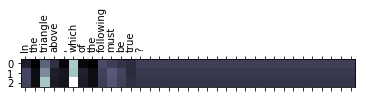

wordId 2
tempQ true


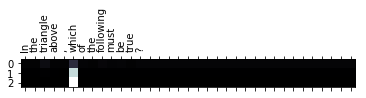

gen_rule true   which
conf 0.073711365
wordId 11
inc_over 31 14
pos_rules ['value x']
line In the figure above , what is the value of x ?
tempQ value


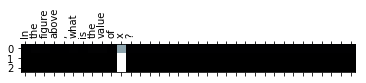

gen_rule value   x
conf 0.074030735
wordId 8
inc_over 32 14
pos_rules ['perimeter rectangle', 'area rectangle']
line The perimeter of the rectangle above is p and the area of the rectangle is 36 .
tempQ perimeter


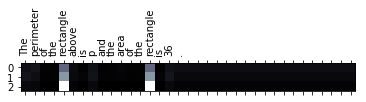

gen_rule perimeter   rectangle
conf 0.038873836
wordId 1
inc_over 33 14
tempQ rectangle


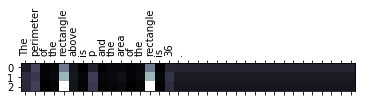

gen_rule rectangle   rectangle
conf 0.031860925
wordId 4
tempQ area


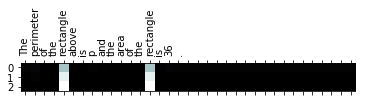

gen_rule area   rectangle
conf 0.045277245
wordId 10
inc_over 34 14
tempQ rectangle


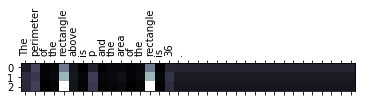

gen_rule rectangle   rectangle
conf 0.031860925
wordId 13
pos_rules ['value p', 'integers l']
line If l and w are integers , what is one possible value of p ?
tempQ value


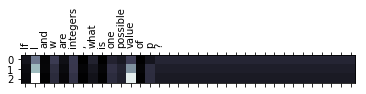

gen_rule value   l
conf 0.03235191
wordId 11
inc fp  14
inc_over 34 15
pos_rules ['value x']
line In the figure above , if the angle ( not shown ) where lines n and p intersect is twice as large as the angle ( also not shown ) where lines l and m intersect , what is the value of x ?
tempQ angle


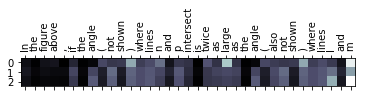

wordId 7
tempQ not


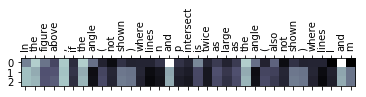

gen_rule not   ,
conf 0.029108
wordId 9
tempQ lines


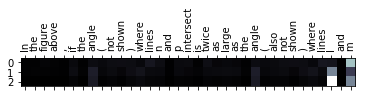

gen_rule lines   l
conf 0.041106004
wordId 13
inc fp  15
inc_over 34 16
tempQ twice


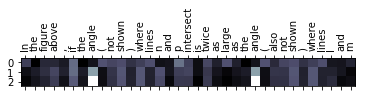

gen_rule twice   angle
conf 0.029765766
wordId 19
inc fp  16
inc_over 34 17
tempQ angle


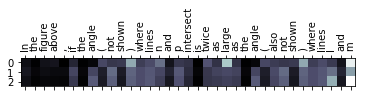

wordId 24
tempQ not


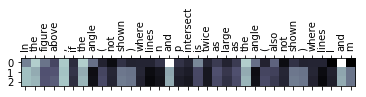

gen_rule not   ,
conf 0.029108
wordId 27
tempQ lines


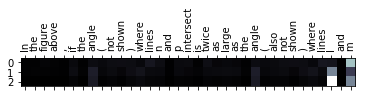

gen_rule lines   l
conf 0.041106004
wordId 31
pos_rules ['points A']
line In the figure above , points A and B lie on the circle with center O .
tempQ points


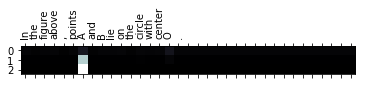

gen_rule points   A
conf 0.07391226
wordId 5
inc_over 35 17
pos_rules ['value z']
line If s holds , what is the value of z ?
tempQ value


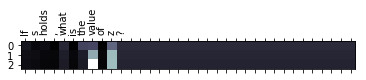

gen_rule value   value
conf 0.0318437
wordId 7
pos_rules ['value x', 'perimeter rectangle']
line If the perimeter of the rectangle above is 72 , what is the value of x ?
tempQ perimeter


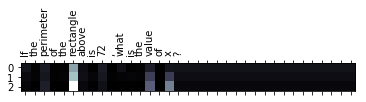

gen_rule perimeter   rectangle
conf 0.036241718
wordId 2
inc_over 36 17
tempQ rectangle


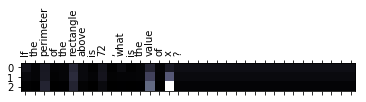

wordId 5
tempQ value


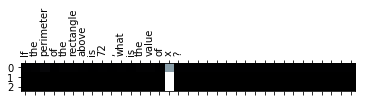

gen_rule value   x
conf 0.07403011
wordId 13
inc_over 37 17
pos_rules ['triangle ABC', 'length AB']
line In triangle ABC above , the length of AB is 3 , and D is the midpoint of AC .
tempQ triangle


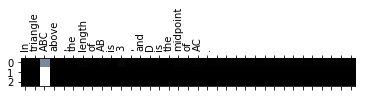

gen_rule triangle   ABC
conf 0.07403073
wordId 1
inc_over 38 17
tempQ length


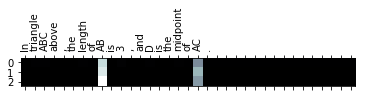

gen_rule length   AB
conf 0.050184578
wordId 6
inc_over 39 17
pos_rules ['length BC']
line What is the length of BC ?
tempQ length


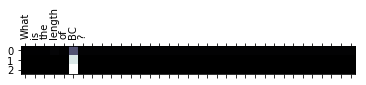

gen_rule length   BC
conf 0.073881954
wordId 3
inc_over 40 17
pos_rules ['area square', 'equilateral triangle']
line In the figure above , CDE is an equilateral triangle and ABCE is a square with an area of 1 .
tempQ equilateral


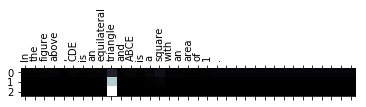

gen_rule equilateral   triangle
conf 0.07387772
wordId 8
inc_over 41 17
tempQ triangle


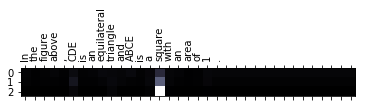

wordId 9
tempQ square


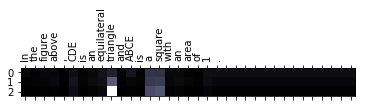

gen_rule square   triangle
conf 0.040658236
wordId 14
inc fp  17
inc_over 41 18
tempQ area


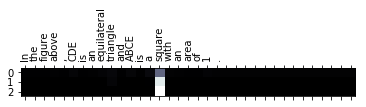

gen_rule area   square
conf 0.073748305
wordId 17
inc_over 42 18
pos_rules ['polygon ABCDE', 'perimeter ABCDE']
line What is the perimeter of polygon ABCDE ?
tempQ perimeter


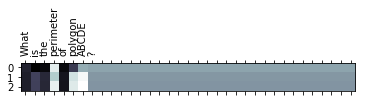

gen_rule perimeter   ABCDE
conf 0.029042693
wordId 3
inc_over 43 18
pos_rules ['area CAF', 'area CDEF', 'triangle CAF', 'rectangle CDEF', 'length AD', 'segment AD']
line In the figure above , if the area of triangle CAF is equal to the area of rectangle CDEF , what is the length of segment AD ?
tempQ area


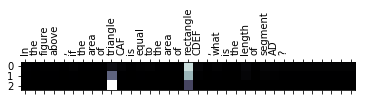

gen_rule area   triangle
conf 0.056038186
wordId 7
inc fp  18
inc_over 43 19
tempQ triangle


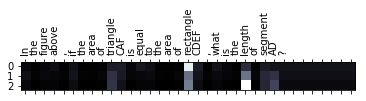

wordId 9
tempQ area


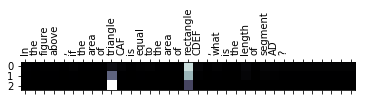

gen_rule area   triangle
conf 0.056038186
wordId 15
tempQ rectangle


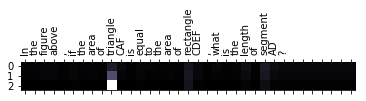

gen_rule rectangle   triangle
conf 0.051502343
wordId 17
inc fp  19
inc_over 43 20
tempQ length


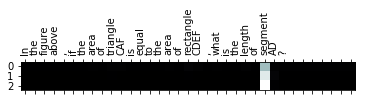

gen_rule length   segment
conf 0.07279362
wordId 23
inc fp  20
inc_over 43 21
tempQ segment


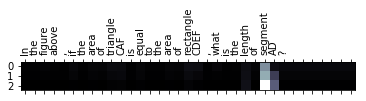

gen_rule segment   segment
conf 0.04760302
wordId 25
pos_rules ['value z']
line If s holds and s holds in the figure above , what is the value of z ?
tempQ value


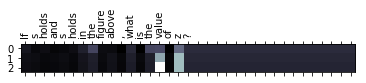

gen_rule value   value
conf 0.032226697
wordId 14
pos_rules ['triangle ABC', 'line AC', 'line AB']
line In triangle ABC above , s holds , E is the midpoint of line AB , and D is the midpoint of line AC .
tempQ triangle


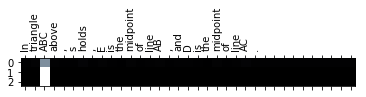

gen_rule triangle   ABC
conf 0.074030735
wordId 1
inc_over 44 21
tempQ line


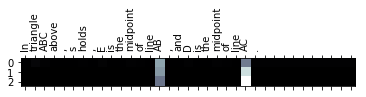

gen_rule line   AC
conf 0.05228289
wordId 13
inc_over 45 21
tempQ line


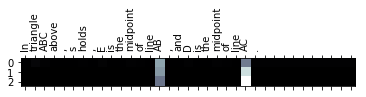

gen_rule line   AC
conf 0.05228289
wordId 22
pos_rules []
line If s holds and s holds , what is length BC ?
tempQ length


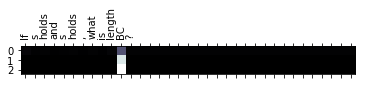

gen_rule length   BC
conf 0.07388689
wordId 9
inc fp  21
inc_over 45 22
pos_rules ['isosceles ABC', 'line AM', 'angle BCA', 'triangle ABC', 'angle BAC', 'line CM']
line In isosceles triangle ABC above , line AM and line CM are the angle bisectors of angle BAC and angle BCA .
tempQ isosceles


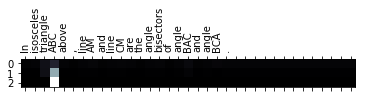

gen_rule isosceles   ABC
conf 0.07386203
wordId 1
inc_over 46 22
tempQ triangle


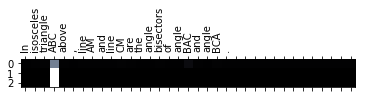

gen_rule triangle   ABC
conf 0.07403036
wordId 2
inc_over 47 22
tempQ line


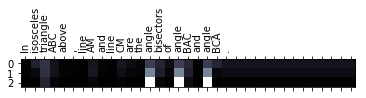

wordId 6
tempQ line


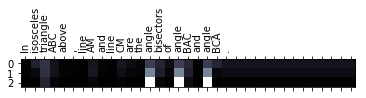

wordId 9
tempQ angle


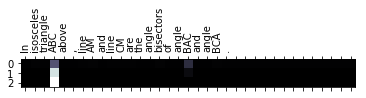

gen_rule angle   ABC
conf 0.07395309
wordId 13
inc fp  22
inc_over 47 23
tempQ angle


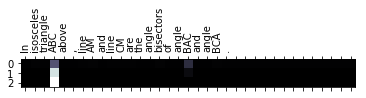

gen_rule angle   ABC
conf 0.07395309
wordId 16
tempQ angle


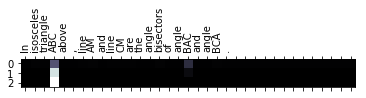

gen_rule angle   ABC
conf 0.07395309
wordId 19
pos_rules ['measure AMC', 'angle AMC']
line What is the measure of angle AMC ?
tempQ measure


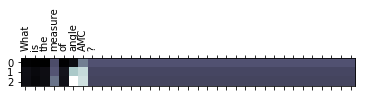

gen_rule measure   angle
conf 0.030143358
wordId 3
inc fp  23
inc_over 47 24
tempQ angle


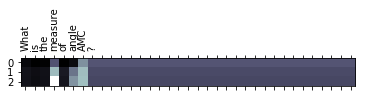

wordId 5
pos_rules ['congruent triangles', 'equilateral triangles']
line The figure above is composed of 25 small triangles that are congruent and equilateral .
tempQ equilateral


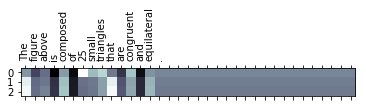

gen_rule equilateral   that
conf 0.029053316
wordId 13
inc fp  24
inc_over 47 25
pos_rules ['area AFK', 'triangle DFH', 'area DFH', 'triangle AFK']
line If the area of triangle DFH is 10 , what is the area of triangle AFK ?
tempQ area


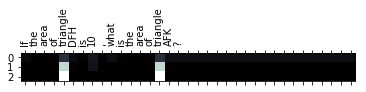

gen_rule area   triangle
conf 0.045393575
wordId 2
inc fp  25
inc_over 47 26
tempQ triangle


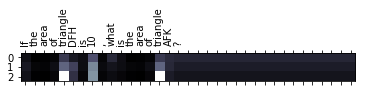

wordId 4
tempQ area


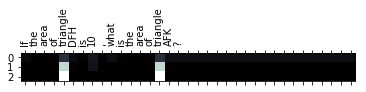

gen_rule area   triangle
conf 0.045393575
wordId 12
tempQ triangle


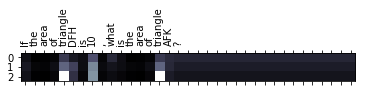

wordId 14
pos_rules []
line In the figure above , a shaded polygon which has equal sides and equal angles is partially covered with a sheet of blank paper .
tempQ sides


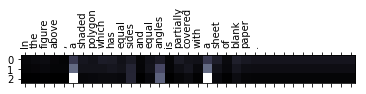

gen_rule sides   a
conf 0.03570496
wordId 11
inc fp  26
inc_over 47 27
tempQ angles


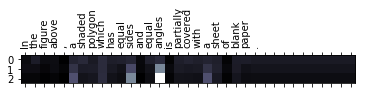

gen_rule angles   angles
conf 0.033064056
wordId 14
pos_rules []
line If s holds , how many sides does the polygon have ?
tempQ sides


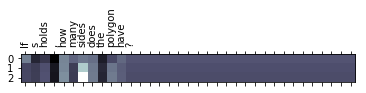

gen_rule sides   sides
conf 0.029604597
wordId 6
pos_rules ['point B', 'line AC']
line In the figure above , point B lies on line AC .
tempQ point


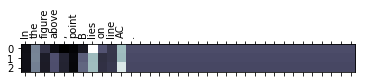

wordId 5
tempQ line


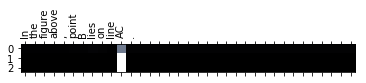

gen_rule line   AC
conf 0.074030735
wordId 9
inc_over 48 27
pos_rules ['value x', 'integers integers']
line If x and y are integers , which of the following is a possible value of x ?
tempQ value


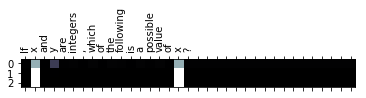

gen_rule value   x
conf 0.045421135
wordId 14
inc_over 49 27
pos_rules ['Point O']
line Point O is the center of both circles in the figure above .
tempQ Point


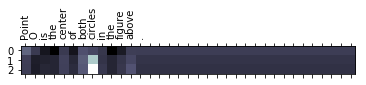

wordId 0
pos_rules ['circumference circle', 'length arc']
line If the circumference of the large circle is 36 and the radius of the small circle is half of the radius of the large circle , what is the length of the darkened arc ?
tempQ radius


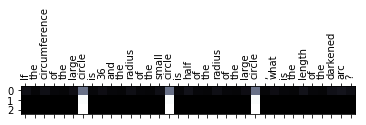

gen_rule radius   circle
conf 0.038566172
wordId 11
inc fp  27
inc_over 49 28
tempQ radius


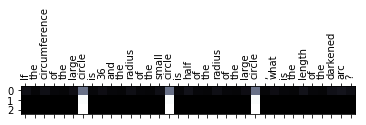

gen_rule radius   circle
conf 0.038566172
wordId 20
tempQ length


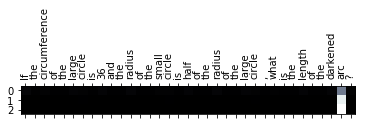

gen_rule length   arc
conf 0.07381122
wordId 29
inc_over 50 28
tempQ arc


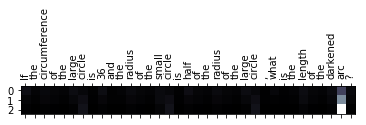

gen_rule arc   arc
conf 0.048751954
wordId 33
pos_rules []
line In the figure above , P , Q , and R lie on the same line .
tempQ line


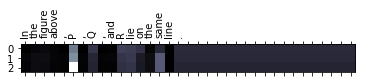

gen_rule line   P
conf 0.032667257
wordId 15
inc fp  28
inc_over 50 29
pos_rules []
line P is the center of the larger circle , and Q is the center of the smaller circle .
pos_rules ['radius circle', 'radius circle']
line If the radius of the larger circle is 4 , what is the radius of the smaller circle ?
tempQ radius


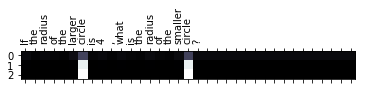

gen_rule radius   circle
conf 0.04541815
wordId 2
inc_over 51 29
tempQ radius


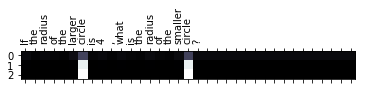

gen_rule radius   circle
conf 0.04541815
wordId 13
pos_rules ['centers R']
line The two semicircles in the figure above have centers R and S , respectively .
tempQ two


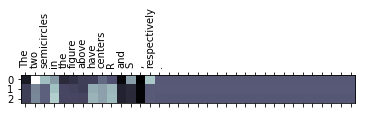

gen_rule two   in
conf 0.02905461
wordId 1
inc fp  29
inc_over 51 30
pos_rules []
line If s holds , what is the total length of the darkened curve ?
tempQ length


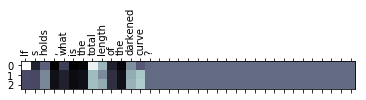

gen_rule length   curve
conf 0.02923362
wordId 8
inc fp  30
inc_over 51 31
pos_rules []
line In the figure above , s holds .
pos_rules []
line Which of the following must equal 180 ?
pos_rules ['three lines']
line In the figure above , three lines intersect at a point .
tempQ lines


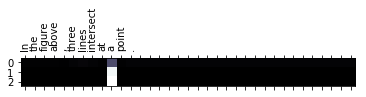

gen_rule lines   a
conf 0.07401839
wordId 6
inc fp  31
inc_over 51 32
tempQ point


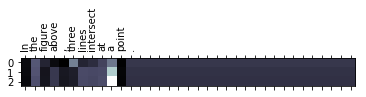

gen_rule point   a
conf 0.029961666
wordId 10
inc fp  32
inc_over 51 33
pos_rules ['value a']
line If s holds and s holds , what is the value of a ?
tempQ value


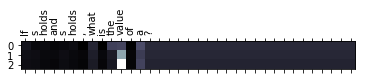

gen_rule value   value
conf 0.03238611
wordId 10
pos_rules ['length AE', 'triangles ABC', 'equilateral ABC', 'line_segment AE']
line In the figure above , triangles ABC and CDE are equilateral and line segment AE has length 25 .
tempQ equilateral


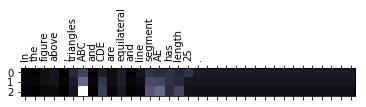

gen_rule equilateral   ABC
conf 0.03252654
wordId 10
inc_over 52 33
tempQ line


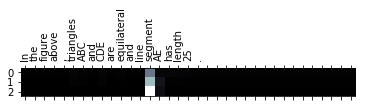

wordId 12
tempQ length


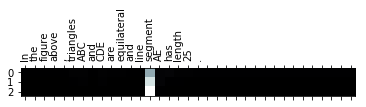

gen_rule length   segment
conf 0.07237831
wordId 16
inc fp  33
inc_over 52 34
pos_rules ['perimeters triangles', 'sum perimeters', 'two triangles']
line What is the sum of the perimeters of the two triangles ?
tempQ sum


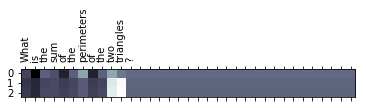

gen_rule sum   triangles
conf 0.029425835
wordId 3
inc fp  34
inc_over 52 35
tempQ two


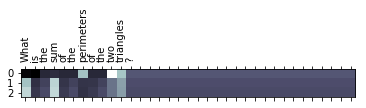

gen_rule two   sum
conf 0.029167674
wordId 9
inc fp  35
inc_over 52 36
pos_rules ['greatest which']
line In the figure above , which of the following is the greatest ?
pos_rules []
line In the figure above , if s holds and s holds , then s is true
tempQ true


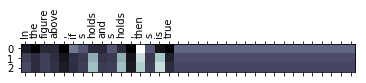

gen_rule true   is
conf 0.02923988
wordId 15
inc fp  36
inc_over 52 37
pos_rules ['triangle PQR']
line In triangle PQR above , s holds .
tempQ triangle


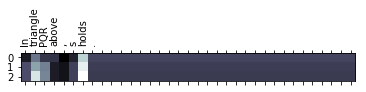

wordId 1
pos_rules ['true Which']
line Which of the following must be true ?
tempQ true


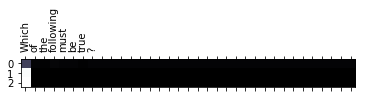

gen_rule true   Which
conf 0.074029006
wordId 6
pos_rules ['perimeter trapezoid']
line What is the perimeter of the trapezoid above ?
tempQ perimeter


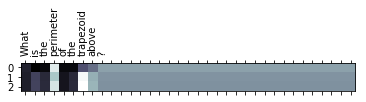

gen_rule perimeter   trapezoid
conf 0.029091047
wordId 3
inc_over 53 37
tempQ trapezoid


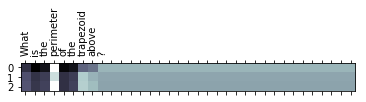

gen_rule trapezoid   perimeter
conf 0.028896274
wordId 6
inc fp  37
inc_over 53 38
pos_rules []
line In the figure above , the smaller circles each have radius 3 .
tempQ radius


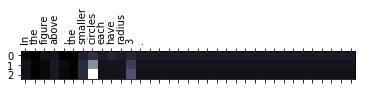

gen_rule radius   circles
conf 0.0326707
wordId 10
inc fp  38
inc_over 53 39
pos_rules ['points A', 'point B']
line They are tangent to the larger circle at points A and C , and are tangent to each other at point B , which is the center of the larger circle .
tempQ points


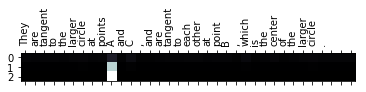

gen_rule points   A
conf 0.073957056
wordId 8
inc_over 54 39
tempQ point


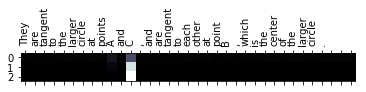

gen_rule point   C
conf 0.07277613
wordId 20
inc fp  39
inc_over 54 40
pos_rules []
line What is the perimeter of the shaded region ?
tempQ perimeter


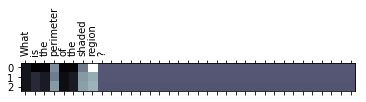

gen_rule perimeter   region
conf 0.029137762
wordId 3
inc fp  40
inc_over 54 41
pos_rules []
line In the figure above , s holds and s holds .
pos_rules ['line AB', 'line CP', 'Point P', 'line AB']
line Point P lies on line AB between A and B such that line CP is perpendicular to line AB .
tempQ Point


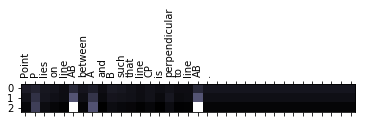

wordId 0
tempQ line


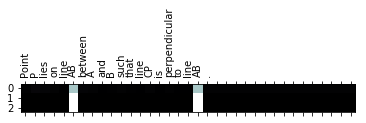

gen_rule line   AB
conf 0.04542252
wordId 4
inc_over 55 41
tempQ line


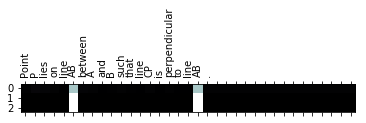

gen_rule line   AB
conf 0.04542252
wordId 12
tempQ line


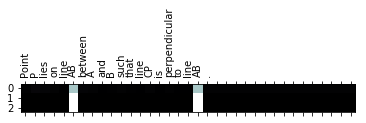

gen_rule line   AB
conf 0.04542252
wordId 17
pos_rules ['length CP', 'line CP']
line Which of the following could be the length of line CP ?
tempQ length


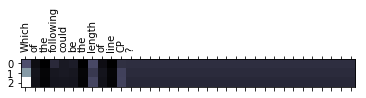

gen_rule length   Which
conf 0.03182554
wordId 7
tempQ line


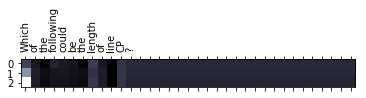

wordId 9
pos_rules ['five lines']
line The figure above shows five lines .
tempQ lines


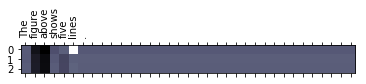

gen_rule lines   lines
conf 0.028626122
wordId 5
pos_rules ['not equal']
line If s holds , which of the following is not equal to 90 ?
tempQ not


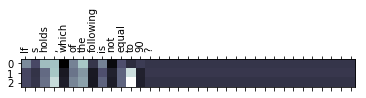

gen_rule not   to
conf 0.02953931
wordId 9
inc fp  41
inc_over 55 42
pos_rules ['length sides', 'three squares']
line The figure above shows three squares with sides of length 5 , 7 , and x , respectively .
tempQ sides


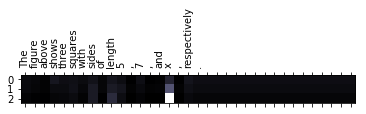

gen_rule sides   x
conf 0.03874368
wordId 7
inc fp  42
inc_over 55 43
tempQ length


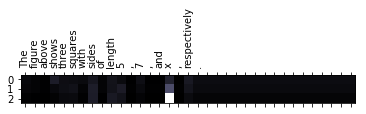

gen_rule length   x
conf 0.042295635
wordId 9
inc fp  43
inc_over 55 44
pos_rules ['value x', 'line l']
line If A , B , and C lie on line l , what is the value of x ?
tempQ line


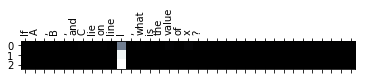

gen_rule line   l
conf 0.07396047
wordId 9
inc_over 56 44
tempQ value


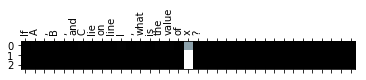

gen_rule value   x
conf 0.074030705
wordId 15
inc_over 57 44
pos_rules ['value y']
line In the figure above , what is the value of y ?
tempQ value


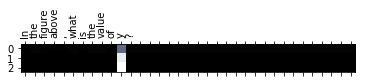

gen_rule value   y
conf 0.073944874
wordId 8
inc_over 58 44
pos_rules ['regular hexagon', 'center O', 'point O']
line In the figure above , ABCDEF is a regular hexagon , and its center is point O .
tempQ point


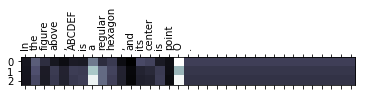

gen_rule point   O
conf 0.030066919
wordId 15
inc_over 59 44
pos_rules ['value x']
line What is the value of x ?
tempQ value


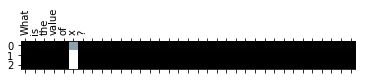

gen_rule value   x
conf 0.074030735
wordId 3
inc_over 60 44
pos_rules ['area circle']
line The circle above has an area of v and is divided into 8 congruent regions .
tempQ area


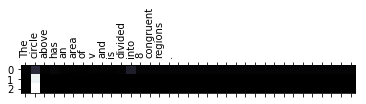

gen_rule area   circle
conf 0.074019454
wordId 5
inc_over 61 44
pos_rules []
line What is the perimeter of these regions ?
tempQ perimeter


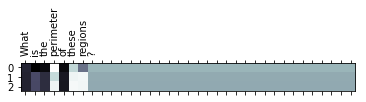

gen_rule perimeter   these
conf 0.028915621
wordId 3
inc fp  44
inc_over 61 45
pos_rules ['point P', 'line l']
line In the figure above , point P is on line l .
tempQ point


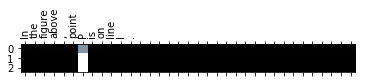

gen_rule point   P
conf 0.07403054
wordId 5
inc_over 62 45
tempQ line


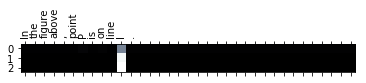

gen_rule line   l
conf 0.07398342
wordId 9
inc_over 63 45
pos_rules ['value x']
line What is the value of x ?
tempQ value


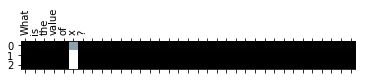

gen_rule value   x
conf 0.074030735
wordId 3
inc_over 64 45
pos_rules ['triangle ABC', 'side AC', 'line l']
line In the figure above , side AC of triangle ABC is on line l .
tempQ side


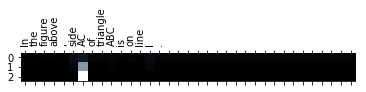

gen_rule side   AC
conf 0.07351853
wordId 5
inc_over 65 45
tempQ triangle


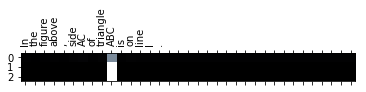

gen_rule triangle   ABC
conf 0.074030735
wordId 8
inc_over 66 45
tempQ line


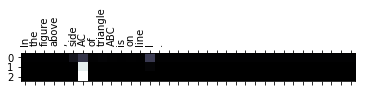

gen_rule line   AC
conf 0.07398935
wordId 12
inc fp  45
inc_over 66 46
pos_rules []
line What is x in terms of k ?
pos_rules ['measure CBA', 'angle CBA']
line What is the measure of angle CBA ?
tempQ measure


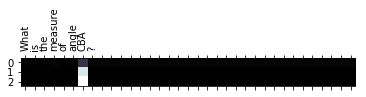

gen_rule measure   CBA
conf 0.07385153
wordId 3
inc_over 67 46
tempQ angle


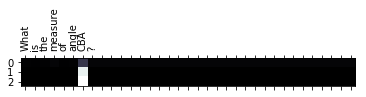

gen_rule angle   CBA
conf 0.07393172
wordId 5
inc_over 68 46
68 46 0 77 0.59649122807 0.468965517241 0.525096525097


In [0]:
# In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD
import re


def predictLong(se, q_position=-1):
    raws = se.split('##')[0].split()
    #   print('raws', raws)
    testS, testQ = se.split('##')
    splitQ = testQ.split(' ')
    tempQ = ' '.join(splitQ[:2])
    tempS = testS + '##' + tempQ + ' point'
    #   print('tempS',tempS)
    #   print('parse_stories2([tempS])',np.array(parse_stories3([tempS])).shape, parse_stories3([tempS]))

    s, q, a, q_position = parse_stories3([tempS], q_position)[0]
    
    
    
    s, q, a = vectorize_data(s, q, a, word_idx, sentence_size, memory_size, q_position)
    print ('tempQ', tempQ)
    #   print('s1',s)
    #   print('q1',q)
    #   print('a1',a)
    a1, att = model2.predict(s, q)
    att = att.reshape(hops, memory_size)
    #   print('att', att.shape)
    plot_attention(raws, [str(i) for i in range(hops)], att)

    #   print('a12', a1)
    if (a1[0] + 1 > len(raws) ):
        return [0]
    predict_word = raws[int(a1[0])]
    if ((tempQ.lower() == 'point') and (len(predict_word) > 1)):
        return [0]
    if ((tempQ.lower() == 'line') and (len(predict_word) > 2)):
        return [0]
    if ((tempQ.lower() in ['angle', 'triangle']) and (len(predict_word) != 3)):
        return [0]
    if ((tempQ.lower() == 'rectangle') and (len(predict_word) <4)):
        return [0]

    if (log_info):
        print('gen_rule', tempQ, ' ', raws[int(a1[0])])
        #         print('last hop', att[-1])
        print('conf', att[-1][a1[0]])
    return a1


def evaluate(lines, keyword_dict, rule_dict=rule_dict):
    single_rule_list = list()
    qs = list()
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for line in lines:
        #     line.replace('\n','')
        #     line = line[:-1]

        selected_rules = list()
        qKey = line.split('##')[0]
        #     print('qKey',qKey)

        pos_rules = list()
        if qKey in rule_dict.keys():
            pos_rules = rule_dict[qKey]

        pos_rule_encs = list()
        pos_rule_encs2 = list()

        for rule in pos_rules:
            #       if(log_info):
            #             print('rule', rule)
            rule_words = rule.split(' ')
            rule1 = [rule_words[0], rule_words[1]]

            #       print('before',[rule_word.replace('@','') for rule_word in rule.split(' ')])
            #       rule_words1 = ''.join([str(word_idx[rule_word.replace('@','')]) for rule_word in rule1])
            rule_words1 = ''.join([str(word_idx[rule_word]) for rule_word in rule1])

            lss1 = ''.join(str(rule_words1))

            #       print('lss',lss1, lss2)
            pos_rule_encs.append(lss1)
        if (log_info):
            print('pos_rules', pos_rules)
        # print('pos_rules_encs',pos_rule_encs)

        line = line.split('##')[1]
        if (log_info):
            print('line', line)
        words = line.split(' ')

        #   pruning
        if (len(words) > memory_size):
            words = words[:memory_size]
            line = ' '.join(words)

        for wordId in range(len(words)):

            #       print('wordId', wordId)
            word = words[wordId]
            #       print(' word ', word)
            if word.lower() in keyword_dict.keys() and keyword_dict[word.lower()] == 1:
                if (word == 'on'):
                    continue               

                if (word.lower() == 'segment' and wordId>0 and  words[wordId - 1] == 'line'):
                    continue

                a1 = predictLong(line + ' ##' + word, wordId)
                if (log_info):
                    print('wordId', wordId)
                pred_word = str(words[a1[0]])
                #         print('pred_word ', pred_word)
                if ((not pred_word.isalnum()) or a1 == [0] or (word == pred_word)):
                    continue
                # print('a1', a1)
                if (word.lower() == 'line' and  words[wordId + 1] == 'segment'):
                    word = word + '_segment'
                    
                if ((word.lower() in ['lies', 'lie']) or (word.lower() == 'is' 
                                                          and words[wordId + 1] == 'on')):
                    word = word + '_on'
                    
                word_id = word_idx[word]
                lss3 = ''.join([str(word_id), str(word_idx[words[a1[0]]])])
                #         single_rule_list.append(qKey+'##'+word+' ' + word_idx.keys()[word_idx.values().index(a1)])
                single_rule_list.append(qKey + '##' + word + ' ' + pred_word)
                if lss3 in selected_rules:
                  continue
                selected_rules.append(lss3)
                #         predicted_rule = word + ' ' +a1
                if containList(lss3, pos_rule_encs, 'tp'):
                    tp = tp + 1
                else:
                    print('inc fp ', fp)
                    fp = fp + 1
                if (log_info):
                    print('inc_over', tp, fp)
                    #                 print('inc_over', tp, fp)
        for pos_rule in pos_rule_encs:
            #       print('ruleId', ruleId)
            #       print('pos_rule_encs', pos_rule_encs, )
            if not containList(pos_rule, selected_rules, 'fp'):
                #                 print('inc fn ', fn)
                fn = fn + 1

    single_rule_list = list(set(single_rule_list))
    predict_single_rule_file = open("predict_single_rule_file_mm.txt", "w+")
    for v in single_rule_list:
        predict_single_rule_file.write(v)
        predict_single_rule_file.write('\n')
    predict_single_rule_file.close()

    return tp, fp, tn, fn


def containList(list1, lists, a):
    if (list1 in lists):
        return True
    return False


# predictLong('In triangle ABC above , the length of AB is 3 , and D is the midpoint of AC .##midpoint D AC')
# predictLong('What is the length of segment AB ?##length AB')

tp, fp, tn, fn = evaluate(evaluate_data, keyword_dict)
precison = 1.0 * tp / (tp + fp)
recall = 1.0 * tp / (tp + fn)
f1Score = 2.0 * precison * recall / (precison + recall)

print(tp, fp, tn, fn, precison, recall, f1Score)


In [0]:
print(tp, fp, tn, fn, precison, recall, f1Score)

61 54 0 84 0.530434782609 0.420689655172 0.469230769231


In [0]:
print(tp, fp, tn, fn, precison, recall, f1Score)

68 46 0 77 0.59649122807 0.468965517241 0.525096525097


In [0]:
101 46 0 44 0.687074829932 0.696551724138 0.691780821918

In [0]:
56 43 0 78 0.565656565657 0.417910447761 0.480686695279
inc 55 43
55 43 0 80 0.561224489796 0.407407407407 0.472103004292

In [0]:
'what'.lower() in keyword_dict.keys() and keyword_dict['what'.lower()] == 1

True

s1 [[[447, 524], [419, 525], [356, 526], [107, 527], [10, 528], [447, 529], [476, 530], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]]
q1 [[447, 524]]
a1 [array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])]
gen_rule line   O


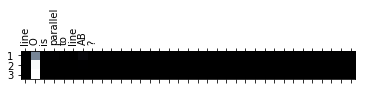

s1 [[[447, 524], [419, 525], [356, 526], [107, 527], [10, 528], [447, 529], [476, 530], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]]
q1 [[447, 524]]
a1 [array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])]
gen_rule line   O


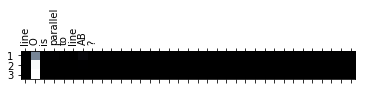

array([1])

In [0]:
# predictLong('What is the length of segment AB ? ##length') 
predictLong('line O is parallel to line AB ? ##line',4) 
 
predictLong('line O is parallel to line AB ? ##line',0) 


In [0]:
line1 = ['1025#0##BCA is a triangle']
evaluate(line1,keyword_dict)

pos_rules ['value x']
line BCA is a triangle


In [0]:
keyword_dict

{'Circle': 1,
 'Diameter': 2,
 'Find': 1,
 'Line': 1,
 'Points': 1,
 'Rectangle': 1,
 'Segment': 1,
 'Triangle': 1,
 'Two': 1,
 'What': 0,
 'altitude': 2,
 'angle': 1,
 'angles': 1,
 'arc': 1,
 'arcs': 1,
 'area': 1,
 'average': 1,
 'be': 2,
 'center': 2,
 'chord': 2,
 'chords': 2,
 'circle': 1,
 'congruent': 2,
 'correct': 1,
 'degrees': 1,
 'diameter': 1,
 'equal': 2,
 'equals': 2,
 'equilateral': 1,
 'has': 2,
 'height': 1,
 'hypotenuse': 2,
 'intersect': 2,
 'intersects': 2,
 'is': 2,
 'isosceles': 1,
 'leg': 2,
 'length': 2,
 'lies': 2,
 'line': 1,
 'lines': 1,
 'measure': 1,
 'measures': 1,
 'meet': 2,
 'midpoints': 2,
 'not': 1,
 'on': 2,
 'parallel': 2,
 'perimeter': 1,
 'perpendicular': 2,
 'point': 1,
 'points': 1,
 'quadrilateral': 1,
 'radius': 1,
 'ratio': 2,
 'rectangle': 1,
 'rhombus': 1,
 'right': 1,
 'secant': 2,
 'secants': 2,
 'sector': 1,
 'segment': 1,
 'side': 2,
 'sides': 2,
 'six': 1,
 'square': 1,
 'sum': 1,
 'tangent': 2,
 'tangents': 2,
 'trapezoid': 1,
 'tri

In [0]:
double_rule_list = list(set(double_rule_list))
for v in double_rule_list:
  print(v)

1470#1##is area What
1482#0##is AB length
1485#0##is area what
1484#3##is area What
1032#0##is D point
1476#0##is value what
1032#0##perpendicular BC point
968#1##is measure what
968#0##is O circle
974#0##is value what
1479#1##is value what
969#0##intersect AB EF
1020#1##is value What
1005#1##center A B
971#0##is area square
1037#1##tangent AB circle
1482#1##is length What
1037#2##is measure length
1027#1##is value What
1479#0##center O circle
1473#0##with AB O
1006#2##be length Which
1473#1##is area What
977#1##is measure What
975#1##is length what
968#0##center circle O
963#1##is value what
1481#0##is value what
1031#0##lies_on AB point
1477#1##is value what
1025#0##is value what
1019#1##is perimeter What
1473#0##center AB O
985#0##lies_on B AC
1031#1##is value What
1005#1##tangent A B
1035#1##is value What
995#1##is sum What
1473#0##is AB O
1467#0##lies_on B AC
1030#0##is value what
993#1##is value what
1037#2##equals length measure
1467#1##is value what
1151#0##is measure What
1037

In [0]:
np.sort([int(val) for val in word_idx.values() if val!='time1'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [0]:
vocab[1]

'illustrates'

In [0]:

for i in range(6):
  s = [[word_idx.keys()[word_idx.values().index(j)]] for j in testS[i][0] if j>0 and j<220]
  print (s)

[['The'], ['measure'], ['of'], ['angle'], ['BAC'], ['equals'], ['@'], ['v_0']]
[['In'], ['the'], ['figure'], ['above'], [','], ['point'], ['B'], ['lies'], ['on'], ['side'], ['AC']]
[['In'], ['rectangle'], ['ABDF'], ['above'], [','], ['C'], ['and'], ['E'], ['are'], ['midpoints'], ['of'], ['sides'], ['BD'], ['and'], ['DF'], [','], ['respectively']]
[['Point'], ['P'], ['is'], ['the'], ['center'], ['of'], ['the'], ['large'], ['circle'], ['and'], ['PA'], ['and'], ['PB'], ['are'], ['radii']]
[['In'], ['the'], ['figure'], ['above'], [','], ['the'], ['circle'], ['with'], ['center'], ['O'], ['has'], ['radius'], ['7'], [','], ['AB'], ['is'], ['a'], ['diameter'], [','], ['and'], ['@'], ['s_0'], ['holds']]
[['In'], ['the'], ['figure'], ['above'], [','], ['the'], ['circle'], ['with'], ['center'], ['O'], ['has'], ['radius'], ['7'], [','], ['AB'], ['is'], ['a'], ['diameter'], [','], ['and'], ['@'], ['s_0'], ['holds']]


In [0]:

for i in range(6):
  s = [[word_idx.keys()[word_idx.values().index(j)]] for j in testQ[i] if j>0 and j<7974]
  print (s)

[['equals']]
[['lies_on'], ['B']]
[['midpoints'], ['C']]
[['center'], ['P']]
[['has'], ['radius']]
[['center'], ['O']]


In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_preds[:6]]

['BAC', 'AC', 'D', 'circle', 'AB', 'AB']

In [0]:
from operator import __mul__
se = [1,2,3]
reduce(__mul__,se,1)

6

In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_labels[:6]]

['measure', 'AC', 'BD', 'circle', '7', 'circle']

In [0]:
testS[5][0]
[j for j in train_labels[5][0]]

42894

In [0]:
testQ[5],trainQ[5],len([a for a in trainQ if sum(p>0 for p in a)>1])

(array([103,  59,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([166,  39,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 90)

In [0]:
word_idx.keys()[word_idx.values().index(3171)]


'In'

In [0]:
len(word_idx)

7974

In [0]:
import re
parse_stories(['In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD',
'In circle O , diameter AC is perpendicular to chord AD at E .##perpendicular AC AD'])

[([['In',
    'circle',
    'O',
    ',',
    'diameter',
    'AB',
    'is',
    'perpendicular',
    'to',
    'chord',
    'CD',
    'at',
    'E']],
  ['perpendicular', 'AB'],
  'CD'),
 ([['In',
    'circle',
    'O',
    ',',
    'diameter',
    'AC',
    'is',
    'perpendicular',
    'to',
    'chord',
    'AD',
    'at',
    'E']],
  ['perpendicular', 'AC'],
  'AD')]

In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_preds[:5]]

[' l', 'le', ' O', 'CD', ' O']

In [0]:
for story in testS[:5]:
  for sentence in story:
    print ([word_idx.keys()[word_idx.values().index(i)] for i in sentence if i!=0 and i!=8010])



['In', 'circle', 'O', ',', 'diameter', 'IB', 'is', 'perpendicular', 'to', 'chord', 'IC', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'IC', 'is', 'perpendicular', 'to', 'chord', 'ID', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'ID', 'is', 'perpendicular', 'to', 'chord', 'IE', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'IE', 'is', 'perpendicular', 'to', 'chord', 'IF', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'IF', 'is', 'perpendicular', 'to', 'chord', 'IG', 'at', 'E']


In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_labels[:5]]

In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_labels[:5]]

['IC', 'ID', 'IE', 'IF', 'IG']

In [0]:
class AB(object):
  def __init__(self):
    self.asw = 5
  def getAs(self):
    return self.asw
  
errw = AB()
print(errw.getAs())

5


In [0]:
# np.argmax(train_preds[0])
# word_idx.keys()[word_idx.values().index(1325)]
len(train_preds)

1600

In [0]:
story12 =  ['The', 'diagram', 'below', 'illustrates', 'the', 'construction', 'of', 'line', 'PS', 'parallel', 'to', 'line', 'RQ', 'through', 'point', 'P']
query12 =  ['parallel']
answer12 =  ['PS']
story12.index(answer12[0])

story12.index(query12[0])

9

In [0]:
data2[0][0]
# max_story_size1 = max(map(len, (s for s, _, _ in data2)))
# mean_story_size = int(np.mean([ len(s) for s, _, _ in data2 ]))
# sentence_size = max(map(len, chain.from_iterable(s for s, _, _ in data2)))
# query_size = max(map(len, (q for _, q, _ in data2)))
# memory_size = min(memory_size, max_story_size)
np.array(trainS2).shape
trainS2[100]

[[522],
 [521],
 [520],
 [519],
 [518],
 [517],
 [136, 516],
 [515],
 [514],
 [513],
 [512],
 [419, 511],
 [510],
 [389, 509],
 [136, 508],
 [507],
 [506],
 [505],
 [504],
 [419, 503],
 [502],
 [407, 501],
 [500],
 [499],
 [498],
 [497],
 [496],
 [495],
 [136, 494],
 [493],
 [11, 492],
 [491],
 [490],
 [0],
 [0]]

In [0]:
len(word_idx)

559

pos_rules ['value x']
line In the figure above , what is the value of x ?
wordId 8
att [[[0.02767446 0.02775258 0.02808488 0.0276481  0.02783513 0.02783608
   0.02765748 0.02763407 0.02779131 0.02802508 0.04845458 0.02806692
   0.02806692 0.02806692 0.02806692 0.02806692 0.02806692 0.02806692
   0.02806692 0.02806692 0.02806692 0.02806692 0.02806692 0.02806692
   0.02806692 0.02806692 0.02806692 0.02806692 0.02806692 0.02806692
   0.02806692 0.02806692 0.02806692 0.02806692 0.02806692]]

 [[0.02723718 0.02723785 0.02723783 0.0272371  0.02723825 0.02723775
   0.02723751 0.02723709 0.0272394  0.02723959 0.07388205 0.0272391
   0.0272391  0.0272391  0.0272391  0.0272391  0.0272391  0.0272391
   0.0272391  0.0272391  0.0272391  0.0272391  0.0272391  0.0272391
   0.0272391  0.0272391  0.0272391  0.0272391  0.0272391  0.0272391
   0.0272391  0.0272391  0.0272391  0.0272391  0.0272391 ]]

 [[0.02723439 0.02723439 0.02723439 0.02723439 0.02723439 0.02723439
   0.02723439 0.02723439 0.02723439 

ValueError: ignored

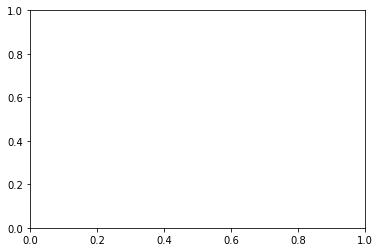

In [0]:
# In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD    
import re



def predictLong(se, q_position = -1):
  raws = se.split('##')[0].split()
#   print('raws', raws)
  testS,testQ =  se.split('##')
  splitQ = testQ.split(' ')
  tempQ = ' '.join(splitQ[:2])
  tempS = testS+'##'+tempQ+' point'
#   print('tempS',tempS)
#   print('parse_stories2([tempS])',np.array(parse_stories2([tempS])).shape, parse_stories2([tempS]))
  
  s,q,a =  parse_stories3([tempS])[0]
  s,q,a = vectorize_data(s, q, a, word_idx, sentence_size,
                         memory_size, q_position = q_position )
#   print ('tempQ',tempQ)
#   print('s1',s)
  a1, att = model2.predict(s,q)
  print('att', att)
  plot_attention([[r] for r in raws],[['1'], ['2'], ['3']],  att)
#   print('a12', a1)
  if(a1[0]+1>len(raws)):
    return [0]
  if(log_info):
    print('rule1', tempQ,' ',raws[int(a1[0])])

  return a1
# #   print('s12',s)
# #   print('a12', a1)
# #   print ('rule', word_idx.keys()[word_idx.values().index(a1)])

#   if(a1[0]+1>len(raws)):
#     return 0,0
#   tempQ = tempQ+' '+ raws[int(a1[0])]
# #   print ('tempQ',tempQ)
#   tempS = testS+'##'+tempQ+' point'
# #   print ('tempS',tempS)
#   _,q,a =  parse_stories3([tempS])[0]
  
#   q = vectorize_question(s,q,a,word_idx, sentence_size, memory_size)
# #   print (s)
# #   print(q)
  
#   a2 = model2.predict(s,q)
# #   print ('rule',a1.shape,a2.shape)
# #   print('a2', a2)
#   if a1!=429 and a2!=429 and a2[0]<len(raws):
#     print('rule1', tempQ,' ',raws[int(a2[0])])
# #     print('rule1', word_idx.keys()[word_idx.values().index(a1)],' ',word_idx.keys()[word_idx.values().index(a2)])
#   return a1, a2
  
  
  
                          
#   print('lenrange',len(splitQ))
#   for i in range(len(splitQ)-1):
# #     print('i',i)
#     tempQ = ' '.join(splitQ[:i+1])
# #   'point'; a dummy answer
#     tempS = testS+'##'+tempQ+' point'
# #     print(tempS)
#     s,q,a =  parse_stories([tempS])[0]
# #     print('s',s)
#     s,q,a = vectorize_data(s,q,a,word_idx, sentence_size, memory_size)
# #     print('len1',len(s)) 
#     print (s)
#     print (q)
#     print ('pred',model.predict(s,q))
#   return s,q
# ad = predictLong('In circle O , diameter AB is perpendicular to chord CD at E .','perpendicular AB CD') 

# np.array(ad).shape,model.predict(s,q)
# model.predict(s,q)

def evaluate(lines,keyword_dict, rule_dict = rule_dict):
  single_rule_list = list()
  qs = list()
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  selected_rules = list()
  for line in lines:
#     line.replace('\n','')
#     line = line[:-1]


    qKey = line.split('##')[0]
#     print('qKey',qKey)
    
    pos_rules = list()
    if qKey in rule_dict.keys():
      pos_rules = rule_dict[qKey]      
    
    pos_rule_encs = list()
    pos_rule_encs2 = list()
    
    for rule in pos_rules:
#       if(log_info):
#             print('rule', rule)
      rule_words = rule.split(' ')
      rule1 = [rule_words[0],rule_words[1]]
      
#       print('before',[rule_word.replace('@','') for rule_word in rule.split(' ')])
#       rule_words1 = ''.join([str(word_idx[rule_word.replace('@','')]) for rule_word in rule1])
      rule_words1 = ''.join([str(word_idx[rule_word.replace('@','')]) for rule_word in rule1])
        
    
      lss1 = ''.join(str(rule_words1))
      
#       print('lss',lss1, lss2)
      pos_rule_encs.append(lss1)
    if(log_info):      
      print('pos_rules',pos_rules)
#     print('pos_rules_encs',pos_rule_encs)
    
    line = line.split('##')[1]
    if(log_info): 
      print('line',line)
    words = line.split(' ')
  
#   pruning
    if(len(words)>memory_size):
      words = words[:memory_size]
      line = ' '.join(words)
  
  
    for wordId in range(len(words)):
      
      word = words[wordId]
#       print(' word ', word)
      if word in keyword_dict.keys() and keyword_dict[word]==1:
        if(word=='on'):
          continue
          
        if((word.lower() in ['lies','lie']) or (word.lower()=='is' and words[wordId+1]=='on' )):
          word =word+'_on'
        print('wordId', wordId)
        a1= predictLong(line+' ##'+word, wordId)
        pred_word = str(words[a1[0]])
#         print('pred_word ', pred_word)
        if(a1 == [0] or (not pred_word.isalnum()) or(pred_word.islower() and len(pred_word)>1)):
          continue
#         print('a1', a1)
        word_id = word_idx[word]
        lss3 = ''.join([str(word_id), str(word_idx[words[a1[0]].replace('@','')]) ])
#         single_rule_list.append(qKey+'##'+word+' ' + word_idx.keys()[word_idx.values().index(a1)])
        single_rule_list.append(qKey+'##'+word+' ' + pred_word)
        selected_rules.append(lss1)
#         predicted_rule = word + ' ' +a1
        if containList(lss3, pos_rule_encs,'tp'):
          tp = tp+1
        else:
          fp = fp+1
        if(log_info):
          print('inc',tp,fp)    
          
    for ruleId in range(len(pos_rule_encs)):
#       print('ruleId', ruleId)    
#       print('pos_rule_encs', pos_rule_encs, )
      if not containList(pos_rule_encs[ruleId], selected_rules,'fp'):
        fn = fn+1

  single_rule_list = list(set(single_rule_list))
  predict_single_rule_file = open("predict_single_rule_file_mm.txt", "w+")                              
  for v in single_rule_list:
    predict_single_rule_file.write(v)
    predict_single_rule_file.write('\n')
  predict_single_rule_file.close()   
                                
          
          
  return tp,fp, tn, fn 

def containList(list1, lists,a):
#   print(a,list1,'##',lists)
#   print('lists',lists)
#   print('list1',list1)
  
#   list_ind =int(''.join(str(x) for x in list1)) 
#   list_ints = list()
  
#   for i in lists:
# #     print('i',i)
# #     print('gen',int(''.join(str(x) for x in i)))
#     list_ints.append(''.join(str(x).strip()) for x in i if len(''.join(str(x)).strip())>0) 
  if (list1 in lists):
    return True
  return False



# predictLong('In triangle ABC above , the length of AB is 3 , and D is the midpoint of AC .##midpoint D AC') 
# predictLong('What is the length of segment AB ?##length AB') 

tp,fp, tn, fn = evaluate(evaluate_data, keyword_dict)
precison = 1.0*tp/(tp+fp)
recall = 1.0*tp/(tp+fn)
f1Score = 2.0*precison*recall/(precison+recall)

print(tp,fp, tn, fn,precison, recall, f1Score)
